In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage import transform
import tensorflow as tf
import seaborn as sns
import tensorflow.keras.backend as K
import os
from random import randint
from random import random
import scipy.misc
from tensorflow.keras.layers import concatenate
from time import time
from multiprocessing import Queue
from datetime import datetime

from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Activation
from tensorflow.keras.models import Sequential
import cv2

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
classs_count = {k:0 for k in range(3)}

In [3]:
classs_count

{0: 0, 1: 0, 2: 0}

In [ ]:
x = np.array(([1, 1, 1, 1]))
y = np.array(([0.8, 0.2, 0.4, 0.501]))
# x = np.array(([1]))
# y = np.array(([1]))

In [ ]:
x = x.reshape(2,2)
y = y.reshape(2,2)

In [ ]:
x, y

(array([[1, 1],
        [1, 1]]), array([[0.8  , 0.2  ],
        [0.4  , 0.501]]))

In [ ]:
accuracy = tf.keras.metrics.BinaryAccuracy()(x,y)
precision = tf.keras.metrics.Precision()(x,y)
recall = tf.keras.metrics.Recall()(x,y)
f1_score = 2*(precision*recall)/(precision+recall + K.epsilon())
f1_score_0 = 2*(precision*recall)/(precision+recall)

In [ ]:
tf.print(accuracy, precision, recall, f1_score, f1_score_0)

0.5 1 0.5 0.666666627 0.666666687


###**Resampling Image**

In [ ]:
pip install nilearn

In [ ]:
# Create the data with numpy
import numpy as np
from nilearn.image import get_data

grid = np.mgrid[0:192, 0:128]
circle = np.sum(
    (grid - np.array([32, 32])[:, np.newaxis, np.newaxis]) ** 2,
    axis=0) < 256
diamond = np.sum(
    np.abs(grid - np.array([128, 80])[:, np.newaxis, np.newaxis]),
    axis=0) < 16
rectangle = np.max(np.abs(
    grid - np.array([64, 96])[:, np.newaxis, np.newaxis]), axis=0) < 16

image = np.zeros_like(circle)
image[16:160, 16:120] = 1.
image = image + 2 * circle + 3 * rectangle + 4 * diamond + 1

vmax = image.max()

source_affine = np.eye(4)
# Use canonical vectors for affine
# Give the affine an offset
source_affine[:2, 3] = np.array([96, 64])
print(source_affine)
# Rotate it slightly
angle = np.pi / 180 * 15
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
source_affine[:2, :2] = rotation_matrix * 2.0  # 2.0mm voxel size
# source_affine[2,2] = 2.0
print(source_affine)
# We need to turn this data into a nibabel image
import nibabel
img = nibabel.Nifti1Image(image[:, :, np.newaxis], affine=source_affine)

[[ 1.  0.  0. 96.]
 [ 0.  1.  0. 64.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[[ 1.93185165 -0.51763809  0.         96.        ]
 [ 0.51763809  1.93185165  0.         64.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


Text(0.5, 1.0, 'The original data in mm space')

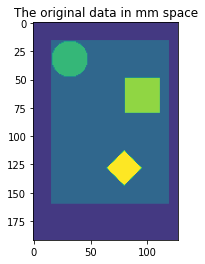

In [ ]:
plt.figure()
plt.imshow(get_data(img)[:, :, 0], vmin=0, vmax=vmax)
plt.title("The original data in mm space")

In [ ]:
from nilearn.image import resample_img
img_in_mm_space = resample_img(img, target_affine=np.eye(4),
                               target_shape=(512, 512, 1))

target_affine_3x3 = np.eye(3) * 2
target_affine_4x4 = np.eye(4) * 2
target_affine_4x4[3, 3] = 1.
img_3d_affine = resample_img(img, target_affine=target_affine_3x3)
img_4d_affine = resample_img(img, target_affine=target_affine_4x4)
target_affine_mm_space_offset_changed = np.eye(4)
target_affine_mm_space_offset_changed[:3, 3] = img_3d_affine.affine[:3, 3]

img_3d_affine_in_mm_space = resample_img(
    img_3d_affine,
    target_affine=target_affine_mm_space_offset_changed,
    target_shape=(np.array(img_3d_affine.shape) * 2).astype(int))

img_4d_affine_in_mm_space = resample_img(
    img_4d_affine,
    target_affine=np.eye(4),
    target_shape=(np.array(img_4d_affine.shape) * 2).astype(int))

/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.6/dist-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


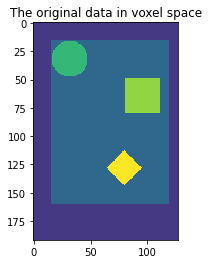

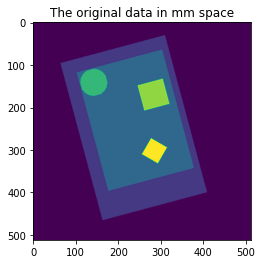

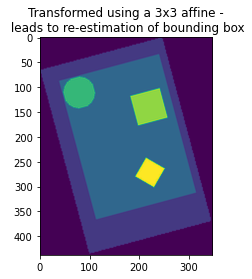

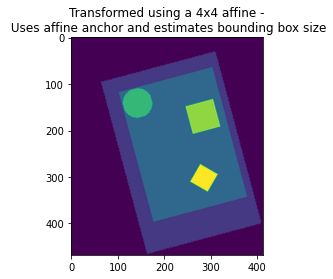

In [ ]:
import matplotlib.pyplot as plt
from nilearn.plotting import show
plt.figure()
plt.imshow(image, interpolation="nearest", vmin=0, vmax=vmax)
plt.title("The original data in voxel space")

plt.figure()
plt.imshow(get_data(img_in_mm_space)[:, :, 0], vmin=0, vmax=vmax)
plt.title("The original data in mm space")

plt.figure()
plt.imshow(get_data(img_3d_affine_in_mm_space)[:, :, 0],
           vmin=0, vmax=vmax)
plt.title("Transformed using a 3x3 affine -\n leads to "
          "re-estimation of bounding box")

plt.figure()
plt.imshow(get_data(img_4d_affine_in_mm_space)[:, :, 0],
           vmin=0, vmax=vmax)
plt.title("Transformed using a 4x4 affine -\n Uses affine anchor "
          "and estimates bounding box size")

show()

###**Segmentation Models**

In [ ]:
pip install segmentation-models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(128, 128, 1))

Segmentation Models: using `keras` framework.


In [ ]:
model.summary(line_length=150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
data (InputLayer)                                [(None, 128, 128, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
bn_data (BatchNormalization)                     (None, 128, 128, 1)              3                 data[0][0]                                        
______________________________________________________________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)                   (None, 134, 134, 1)         

###**Understanding Feature Maps**

In [ ]:
img = cv2.imread('img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

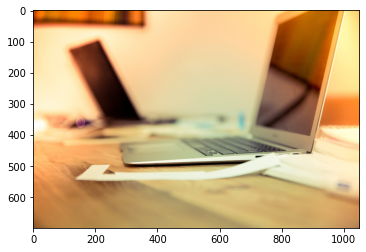

In [ ]:
plt.imshow(img)

In [ ]:
model = Sequential()
model.add(Convolution2D(3, (3, 3), input_shape=img.shape, activation= 'relu'))
model.add(Convolution2D(6, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(9, (3, 3), activation='relu', padding='same'))

In [ ]:
img = img[None]

In [ ]:
img.shape

(1, 700, 1050, 3)

In [ ]:
img = model(img)
# img = img[0]

In [ ]:
img.shape

TensorShape([1, 698, 1048, 9])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 698, 1048, 3)      84        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 698, 1048, 6)      168       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 698, 1048, 9)      495       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 698, 1048, 9)      738       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 698, 1048, 9)      738       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 698, 1048, 9)      738       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 698, 1048, 9)    

0


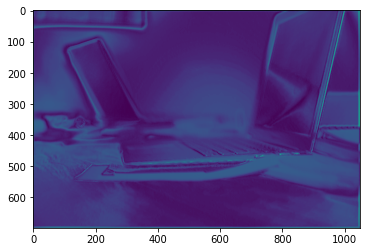

1


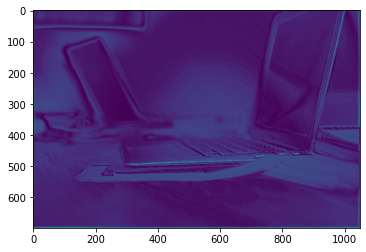

2


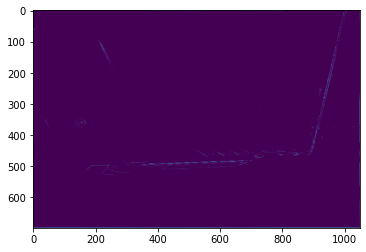

3


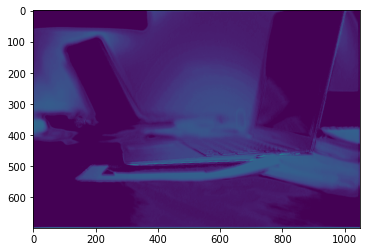

4


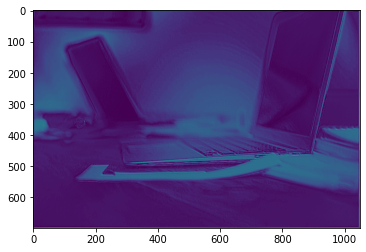

5


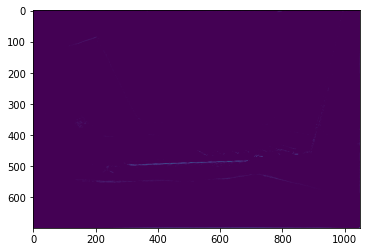

6


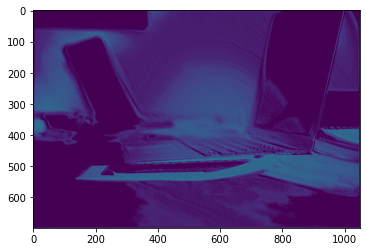

7


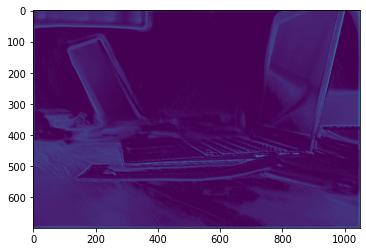

8


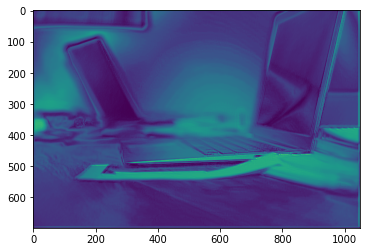

In [ ]:
for i in range(img.shape[-1]):
  print(i)
  plt.imshow(img[0,:,:,i])
  plt.show()

In [ ]:
# model.weights

###**Understanding PDFs**

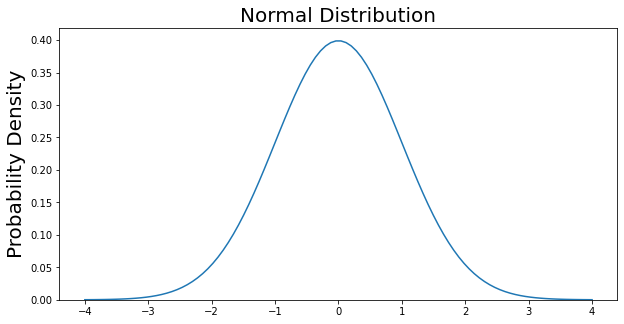

In [ ]:
# Import all libraries for this portion of the blog post
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(-4, 4, num = 100)
constant = 1.0 / np.sqrt(2*np.pi)
pdf_normal_distribution = constant * np.exp((-x**2) / 2.0)
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(x, pdf_normal_distribution);
ax.set_ylim(0);
ax.set_title('Normal Distribution', size = 20);
ax.set_ylabel('Probability Density', size = 20);

In [ ]:
# Make PDF for the normal distribution a function
def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )
# Integrate PDF from -.6745 to .6745
result_50p, _ = quad(normalProbabilityDensity, -.6745, .6745, limit = 1000)
print(result_50p)

0.5000065142726018


In [ ]:
# Make a PDF for the normal distribution a function
def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )
# Integrate PDF from -2.698 to 2.698
result_99_3p, _ = quad(normalProbabilityDensity,
                     -2.698,
                     2.698,
                     limit = 1000)
print(result_99_3p)

0.9930242559336101


###**N4 Bias correction**

In [ ]:
import SimpleITK as sitk

def N4():
    inputImagePath = project_path + 'tDataset/d001_int1_dat.nii.gz'
    inputImage = sitk.ReadImage(inputImagePath)

    print("N4 bias correction runs.")

    maskImage = sitk.ReadImage(project_path + 'tDataset/d001_int1_seg.nii.gz')
    maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
    maskImagePath = project_path + 'tDataset/out/mask.nii.gz'
    sitk.WriteImage(maskImage, maskImagePath)
    print("Mask image is saved.")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    output = corrector.Execute(inputImage,maskImage)

    outputPath = project_path + 'tDataset/out/img.nii.gz'
    sitk.WriteImage(output,outputPath)
    print("Finished N4 Bias Field Correction.....")

###**zero_centered_coordinate_mesh**

In [ ]:
def create_zero_centered_coordinate_mesh(shape):
    tmp = tuple([np.arange(i) for i in shape])
    coords = np.array(np.meshgrid(*tmp, indexing='ij')).astype(float)
    print(np.unique(coords[0], return_counts=True))
    print(coords.shape)
    for d in range(len(shape)):
        coords[d] -= ((np.array(shape).astype(float) - 1) / 2.)[d]
    return coords

In [ ]:
shape = [64, 64, 64]

In [ ]:
coords = create_zero_centered_coordinate_mesh(shape)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.]), array([4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096]))
(3, 64, 64, 64)


In [ ]:
coords.shape

(3, 64, 64, 64)

In [ ]:
coords_mean = coords.mean(axis=tuple(range(1, len(coords.shape))), keepdims=True)

In [ ]:
coords_mean.shape, coords_mean

((3, 1, 1, 1), array([[[[0.]]],
 
 
        [[[0.]]],
 
 
        [[[0.]]]]))

In [ ]:
((np.array(shape).astype(float) - 1) / 2.)

array([31.5, 31.5, 31.5])

In [ ]:
np.unique(coords[2], return_counts=True)

(array([-31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5,
        -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5,
        -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,
         -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,
          4.5,   5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,
         13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,
         22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,  30.5,
         31.5]),
 array([4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
        4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
        4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
        4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
        4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
        4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096]))

In [ ]:
x = np.arange(60).reshape((3,4,5))

In [ ]:
x, x.shape

(array([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],
 
        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]],
 
        [[40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49],
         [50, 51, 52, 53, 54],
         [55, 56, 57, 58, 59]]]), (3, 4, 5))

###**3D Patches**

In [ ]:
from numpy.lib import stride_tricks

def cutup(data, blck, strd):
    sh = np.array(data.shape)
    blck = np.asanyarray(blck)
    strd = np.asanyarray(strd)
    nbl = (sh - blck) // strd + 1
    strides = np.r_[data.strides * strd, data.strides]
    dims = np.r_[nbl, blck]
    data6 = stride_tricks.as_strided(data, strides=strides, shape=dims)
    return data6.reshape(-1, *blck)

#demo
x = np.zeros((256, 256, 86), int)
y = cutup(x, (128, 128, 64), (32, 32, 16))

In [ ]:
x.shape, y.shape

((256, 256, 86), (50, 128, 128, 64))

In [ ]:
y[...] = 1
print(x[..., 0], '\n')
print(x[:, 0, :], '\n')
print(x[0, ...], '\n')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 



In [ ]:
for i in range(y.shape[0]):
  for j in range(y.shape[1]):
    for k in range(y.shape[2]):
      print(y[i,j,k].shape)

###**Roll Axis**

In [ ]:
a = np.ones((3,4,5,6))

In [ ]:
a.shape

(3, 4, 5, 6)

In [ ]:
np.rollaxis(a, 3, 1).shape

(3, 6, 4, 5)

In [ ]:
np.rollaxis(a, 2).shape

(5, 3, 4, 6)

In [ ]:
np.rollaxis(a, 1, 4).shape

(3, 5, 6, 4)

###**Zip and Enumerate**

In [ ]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
b = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i,(x,y) in enumerate(zip(a, b)):
  print(i, x, y)

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9


###**Visualizations**

In [ ]:
def get_unet_eq_vis(inp, outp):
    inputs = Input((img_rows, img_cols, 1))
    nf = 32
    d_rate = 0.2
    reg_factor = 0.0
    SpatialDropout2D(d_rate)
    conv1 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv = tf.keras.activations.relu(conv1)
    # conv1 = Conv2D(nf, (3, 3), padding='same')(conv1)
    # conv1 = BatchNormalization()(conv1)
    # conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #convx = Conv2D(nf, (10, 10), kernel_regularizer=l1(reg_factor), padding='same')(inputs)
    #convx = BatchNormalization()(convx)
    #convx = tf.keras.activations.relu(convx)
    #poolx = MaxPooling2D(pool_size=(2, 2))(convx)
    #pool1 = concatenate([pool1, poolx], axis=3)

    SpatialDropout2D(d_rate)
    conv2 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    # conv2 = Conv2D(nf * 2, (3, 3), padding='same')(conv2)
    # conv2 = BatchNormalization()(conv2)
    # conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    SpatialDropout2D(d_rate)
    conv3 = Conv2D(nf * 4, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    # conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    # conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    SpatialDropout2D(d_rate)
    conv4 = Conv2D(nf * 8, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    # conv4 = Conv2D(nf * 8, (3, 3), padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    SpatialDropout2D(d_rate)
    conv5 = Conv2D(nf * 64, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool4)
    # conv5 = Conv2D(, (1, 1), activation='relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    # conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = tf.keras.activations.relu(conv5)

    up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    # SpatialDropout2D(d_rate)
    # conv6 = Conv2D(nf * 8, (3, 3), padding='same')(conv6)
    # conv6 = BatchNormalization()(conv6)
    # conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    # up7 = conv3
    SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3),kernel_regularizer=l1(reg_factor), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    SpatialDropout2D(d_rate)
    # conv7 = Conv2D(nf * 4, (3, 3),  padding='same')(conv7)
    # conv7 = BatchNormalization()(conv7)
    # conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    SpatialDropout2D(d_rate)
    conv8 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    # SpatialDropout2D(d_rate)
    # conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(conv8)
    # conv8 = BatchNormalization()(conv8)
    # conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    # SpatialDropout2D(d_rate)
    # conv9 = Conv2D(nf, (3, 3), padding='same')(conv9)
    # conv9 = BatchNormalization()(conv9)
    # conv9 = tf.keras.activations.relu(conv9)

    SpatialDropout2D(d_rate)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # model = Model(inputs, outputs)
    model = Model(inputs=[inp], outputs=[outp])
    model.compile(optimizer=Adam(lr=1e-3), loss=tversky_loss, metrics=[dice_coef, precision, recall])
    
    return model

In [ ]:
model = get_unet_eq()

# batch_size = 1
# model.load_weights('model_get_unet_eq_64f_w.h5')
# model.compile(optimizer=Adam(lr=1e-3), loss=tversky_loss, metrics=[dice_coef, precision, recall])

In [ ]:
model1 = get_unet_eq_vis([model.layers[0]], [model.layers[39]])

In [ ]:
model.summary()

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
  # if 'input' in layer.name
	# if 'conv' not in layer.name:
	# 	continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

In [ ]:
model.layers[39].name

'conv2d_219'

In [ ]:
model2 = get_unet_eq_vis(model.layers[0], model_layers[39])

###**Models from library**

In [ ]:
#https://github.com/lixiaolei1982/Keras-Implementation-of-U-Net-R2U-Net-Attention-U-Net-Attention-R2U-Net.-
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply
from keras.layers import concatenate, core, Dropout
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K


def up_and_concate(down_layer, layer, data_format='channels_first'):
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])

    return concate


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate


def attention_block_2d(x, g, inter_channel, data_format='channels_first'):
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x


def res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

              padding='same', data_format='channels_first'):
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    layer = input_layer
    for i in range(2):
        layer = Conv2D(out_n_filters // 4, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)
        if batch_normalization:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        layer = Conv2D(out_n_filters // 4, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
        layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer
    out_layer = add([layer, skip_layer])
    return out_layer


# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

                  padding='same', data_format='channels_first'):
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):

        for i in range(2):
            if i == 0:

                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                    layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    out_layer = add([layer, skip_layer])
    return out_layer

########################################################################################################
#Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def r2_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((3, img_w, img_h))
    x = inputs
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model


########################################################################################################
#Attention R2U-Net
def att_r2_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((3, img_w, img_h))
    x = inputs
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model

In [ ]:
#Attention U-Net
def att_unet(img_w, img_h):
    data_format='channels_last'
    inputs = Input((img_w, img_h, 1))
    x = inputs
    depth = 4
    features = 16
    skips = []
    for i in range(depth):
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_last')(x)
        features = features * 2

    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(1, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [ ]:
# U Net
def unet(img_w, img_h):
    data_format='channels_last'
    inputs = Input((img_w, img_h, 1))
    x = inputs
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format= data_format)(x)
        features = features * 2

    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    for i in reversed(range(depth)):
        features = features // 2
        x = up_and_concate(x,skips[i])
        x = UpSampling2D(size=(2, 2), data_format=data_format)(x)
        x = concatenate([skips[i], x], axis=1)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(1, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)

    model.compile(optimizer=Adam(lr=1e-7), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [ ]:
att_model = att_unet(img_rows, img_cols)
history_att=att_model.fit(imgs_train2, masks_train2, batch_size=20, epochs=100, verbose=1, shuffle=True,
              validation_data = (imgs_val2, masks_val2))
att_model.save('att_model.h5')
att_model.save_weights('w2_att_model.h5')
plot_hist(att_model)

###**Load one record**

In [ ]:
imgs = np.load()

In [ ]:
def get_fsr():
  fsr = np.ndarray((len(spr)), dtype = 'uint16')
  fsr[0] = 0
  for i in range(1, len(spr)):
    fsr[i] = fsr[i-1] + spr[i-1]
    # print(fsr[i-1])
  print(fsr)
  np.save('fsr.npy', fsr)
  return fsr

###**Kernel Visualization**

In [ ]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))
            # n = 10

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

In [ ]:
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
    # the name of the layer we want to visualize
    # (see model definition at keras/applications/vgg16.py)
    LAYER_NAME = 'block5_conv1'

    # build the VGG16 network with ImageNet weights
    # vgg = vgg16.VGG16(weights='imagenet', include_top=False)
    vgg = load_model('model_get_eq_tversky_m.h5')
    print('Model loaded.')
    vgg.summary()

    # example function call
    # visualize_layer(vgg, LAYER_NAME)

ValueError: ignored

###**Lesion Intensity Distribution**

In [ ]:
def les_int_dist(imgs, masks):
    imgs_rec = np.ndarray((nslices, img_rows, img_cols, 1))
    masks_rec = np.ndarray((nslices, img_rows, img_cols, 1))
    for ind in len(spr):
      imgs_record = imgs[ind*nslices : (ind+1)*nslices]
      masks_rec = masks[ind*nslices : (ind+1)*nslices]
      imgs_record[masks_rec = 1]

In [ ]:
l1 = [1, 2, 10 , 11]
l2 = [4,5,6,7, 8]
l2 = np.append(l1, l2)
l2

array([ 1,  2, 10, 11,  4,  5,  6,  7,  8])

###**Confusion matrix**

In [ ]:
  tf.math.confusion_matrix([0, 1, 1], [0.1, 1, 1])

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 0],
       [0, 2]], dtype=int32)>

In [ ]:
def get_t_score(y_true, y_pred):
    cm = tf.math.confusion_matrix(y_true, y_pred, dtype='float32')
    print(cm)
    alpha = 4.0
    beta = 1.0
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    print(tn, fp, fn, tp)
    t_score = 5.0*tp/(5.0*tp + alpha*fn + beta*fp)
    return t_score

In [ ]:
l = tf.constant([0, 1, 1])
p = tf.constant([0.1, 0.1, 0.8])
t_score = get_t_score(l,p)
print(t_score)

tf.Tensor(
[[1. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
round(0.9)

1

###**Train Val Split**

In [ ]:
def split_train_val_random(imgs_train2_f, masks_train2_f, gslice_ind2_eq_f):
  # rft = 36
  tr_ind = np.random.choice(range(len(spr)), rft, replace=False)
  val_ind = list(set(range(len(spr))) - set(tr_ind))
  print(tr_ind, val_ind)
  ex_ind = [4, 16, 28, 39, 40, 50] #6 records 54 - 6 = 48 
  # 36 for train, 6 for val, 6 for test
  tr_ind = [ 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
  val_ind = [41, 42]# 43, 44, 45, 46]
  test_ind = [47, 48, 49, 51, 52, 53]
  print(tr_ind, val_ind)
  print(len(tr_ind), len(val_ind))
  imgs_train2 = np.ndarray((rft*nslices, img_rows, img_cols, 1))
  masks_train2 = np.ndarray((rft*nslices, img_rows, img_cols, 1))
  gslice_ind2_eq_train = np.ndarray((rft*nslices), dtype = 'uint32')
  # imgs_val2 = np.ndarray(((len(spr)-rft)*nslices, img_rows, img_cols, 1))
  # masks_val2 = np.ndarray(((len(spr)-rft)*nslices, img_rows, img_cols, 1))
  # gslice_ind2_eq_val = np.ndarray((len(spr)-rft)*nslices)
  imgs_val2 = np.ndarray(((len(val_ind))*nslices, img_rows, img_cols, 1))
  masks_val2 = np.ndarray(((len(val_ind))*nslices, img_rows, img_cols, 1))
  gslice_ind2_eq_val = np.ndarray((len(val_ind))*nslices)

  for i, ind in enumerate(tr_ind):
    print(i, ind)
    imgs_train2[nslices*i:nslices*(i+1)] = imgs_train2_f[nslices*ind:nslices*(ind+1)]
    masks_train2[nslices*i:nslices*(i+1)] = masks_train2_f[nslices*ind:nslices*(ind+1)]
    gslice_ind2_eq_train[nslices*i:nslices*(i+1)] = gslice_ind2_eq_f[nslices*ind:nslices*(ind+1)]
  for i, ind in enumerate(val_ind):
    print(i, ind)
    imgs_val2[nslices*i:nslices*(i+1)] = imgs_train2_f[nslices*ind:nslices*(ind+1)]
    masks_val2[nslices*i:nslices*(i+1)] = masks_train2_f[nslices*ind:nslices*(ind+1)]
    gslice_ind2_eq_val[nslices*i:nslices*(i+1)] = gslice_ind2_eq_f[nslices*ind:nslices*(ind+1)]

  return imgs_train2, masks_train2, imgs_val2, masks_val2,  gslice_ind2_eq_train, gslice_ind2_eq_val

In [ ]:
def split_train_val(imgs, masks, gslice_ind2, k):
  split_val = int(len(imgs)*k)
  print(split_val)
  # imgs_val2 = imgs_train2[]
  imgs_val2 = imgs[split_val:]
  masks_val2 = masks[split_val:]
  gslice_ind_val2 = gslice_ind2[split_val:]
  
  imgs_train2 = imgs[:split_val]
  masks_train2 = masks[:split_val]
  gslice_ind_train2 = gslice_ind2[:split_val]
  print(len(imgs_train2), len(imgs_val2))
  return imgs_train2, masks_train2, imgs_val2, masks_val2, gslice_ind_train2, gslice_ind_val2

In [ ]:
# recreate random array:
x = np.random.random((43))

# pick your indices for sample 1 and sample 2:
s1 = np.random.choice(range(43), 40, replace=False)
s2 = list(set(range(x.shape[0])) - set(s1))
print(s1, s2)
# extract your samples:
sample1 = x[s1]
sample2 = x[s2]
print(sample1, sample2)
print(sample1.shape, sample2.shape)

[14 25 20  5 35 36  1 11 23  8 27 29 10 26 38 19 24 22 21 31  2  0 16 13
 33 37 34  7 39 18  6 41  9 15  4 42 12 28 17 32] [40, 3, 30]
[0.77214137 0.58862286 0.28628423 0.56457408 0.58575383 0.57586755
 0.1082541  0.11723493 0.41571745 0.9797929  0.81026334 0.35497054
 0.67777946 0.624813   0.54880026 0.11695732 0.6547683  0.53865831
 0.54789219 0.67395859 0.34035227 0.56567322 0.06199748 0.31973848
 0.42296501 0.44487048 0.05566979 0.16449929 0.35636372 0.0972205
 0.87447955 0.04281867 0.60751969 0.85775372 0.03841333 0.11674387
 0.05924494 0.26822727 0.89121839 0.52789082] [0.67432956 0.41581917 0.73816822]
(40,) (3,)


In [ ]:
def get_final_data(imgs_train2_eq, masks_train2_eq, gslice_ind2_eq):
  ''''
  Manual Splitting Data
  ''''
  test_ind = [41, 43, 44, 45, 46, 48]
  val_ind = [42, 46, 49, 52, 53]
  train_ind = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
  imgs_train = np.ndarray((len(train_ind)*nslices, img_rows, img_cols, 1), dtype = np.float32)
  masks_train = np.ndarray((len(train_ind)*nslices, img_rows, img_cols, 1), dtype = np.float32)
  imgs_val = np.ndarray((len(val_ind)*nslices, img_rows, img_cols, 1), dtype = np.float32)
  masks_val = np.ndarray((len(val_ind)*nslices, img_rows, img_cols, 1), dtype = np.float32)
  gslice_ind_train = np.ndarray((len(train_ind)*nslices), dtype = np.uint32)
  gslice_ind_val = np.ndarray((len(val_ind)*nslices), dtype = np.uint32)
  for x, ind in enumerate(train_ind):
    imgs_train[x*nslices:(x+1)*nslices] = imgs_train2_eq[ind*nslices:(ind+1)*nslices]
    masks_train[x*nslices:(x+1)*nslices] = masks_train2_eq[ind*nslices:(ind+1)*nslices]
    gslice_ind_train[x*nslices:(x+1)*nslices] = gslice_ind2_eq[ind*nslices:(ind+1)*nslices]
  for x, ind in enumerate(val_ind):
    imgs_val[x*nslices:(x+1)*nslices] = imgs_train2_eq[ind*nslices:(ind+1)*nslices]
    masks_val[x*nslices:(x+1)*nslices] = masks_train2_eq[ind*nslices:(ind+1)*nslices]
    gslice_ind_val[x*nslices:(x+1)*nslices] = gslice_ind2_eq[ind*nslices:(ind+1)*nslices]
  return imgs_train, masks_train, gslice_ind_train, imgs_val, masks_val, gslice_ind_val

In [ ]:
imgs_train2, masks_train2, gslice_ind_train2, imgs_val2, masks_val2, gslice_ind_val2 = get_final_data(imgs_train2_eq, masks_train2_eq, gslice_ind2_eq)

###**Shuffle -> Batch -> Repeat**

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(1, 21)) 
data = dataset.batch(5).shuffle(20)
for element in data.as_numpy_iterator(): 
  print(element)

[16 17 18 19 20]
[ 6  7  8  9 10]
[1 2 3 4 5]
[11 12 13 14 15]


###**Slicing**

In [ ]:
t = tf.constant([[[1, 1, 1, 2], [2, 2, 2, 7]],
                 [[3, 3, 3, 5], [4, 4, 4, 8]],
                 [[5, 5, 5, 6], [6, 6, 6, 9]]])

In [ ]:
t

<tf.Tensor: shape=(3, 2, 4), dtype=int32, numpy=
array([[[1, 1, 1, 2],
        [2, 2, 2, 7]],

       [[3, 3, 3, 5],
        [4, 4, 4, 8]],

       [[5, 5, 5, 6],
        [6, 6, 6, 9]]], dtype=int32)>

In [ ]:
x = tf.slice(t, [0], [1])

InvalidArgumentError: ignored

In [ ]:
x = t[1]

In [ ]:
x

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[3, 3, 3, 5],
       [4, 4, 4, 8]], dtype=int32)>

In [ ]:
tf.slice(t, [0, 0, 0], [2, 2, 4])  # [[[3, 3, 3]]]

<tf.Tensor: shape=(2, 2, 4), dtype=int32, numpy=
array([[[1, 1, 1, 2],
        [2, 2, 2, 7]],

       [[3, 3, 3, 5],
        [4, 4, 4, 8]]], dtype=int32)>

In [ ]:
tf.slice(t, [1, 0, 0], [1, 2, 3])  # [[[3, 3, 3],
                                   #   [4, 4, 4]]]

In [ ]:
tf.slice(t, [1, 0, 0], [2, 1, 3])  # [[[3, 3, 3]],
                                   #  [[5, 5, 5]]]

###**Using gradient tape()**

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  # pr = []
  g.watch(x)
  y = x * x
  # pr = np.append(pr, y)
  y += x * x * x
  # pr = np.append(pr, y)
  # y = np.mean(pr)
  # y = (y1 + y2)/3
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

tf.Tensor(33.0, shape=(), dtype=float32)


In [ ]:
### Average dice value during the train
## Loss fn assumes entire input as One patient record
train_steps = 1000
model = get_unet()
opt = tf.optimizers.Adam(lr=1e-3)
batch_size = 2
def train():
  epoch = 0
  for step in range(train_steps):
    img_batch = imgs_train2[nslices*step%(rft*nslices):(nslices*(step+batch_size))%(rft*nslices)]
    mask_batch = masks_train2[nslices*step%(rft*nslices):(nslices*(step+batch_size))%(rft*nslices)]
    # print(img_batch.shape, mask_batch.shape)
  
    with tf.GradientTape() as tape:
      varis = model.trainable_variables
      tape.watch(varis)
      logits = model(img_batch)
      dice_score = dice_coef2(mask_batch, logits)
      dice_loss = tf.convert_to_tensor(1.0 - dice_score)
    grads = tape.gradient(dice_loss, varis)
    # print(dice_loss)
    opt.apply_gradients(zip(grads, varis))

    # with tf.GradientTape() as tape:
    #   varis = model.trainable_variables
    #   tape.watch(varis)
    #   dice_pr = 0
    #   for i in range(batch_size):
    #     logits = model(img_batch[nslices*i:nslices*(i+1)])
    #     dice_pr += dice_coef(mask_batch[nslices*i:nslices*(i+1)], logits)
    #   dice_score = (dice_pr)/batch_size
    #   dice_loss = tf.convert_to_tensor(1.0 - dice_score)
    #   # print(dice_loss)
    # grads = tape.gradient(dice_loss, varis)
    # opt.apply_gradients(zip(grads, varis))

    # print("Step: {} Loss: {:.5f} Accuracy: {:.5f}".format(step, dice_loss, dice_score))
    # break
    if not step % int((rft/batch_size)):
      epoch +=1
      dice_pr = 0
      for i in range(int(imgs_val2.shape[0]/nslices)):
        logits = model(imgs_val2[nslices*i:nslices*(i+1)])
        dice_pr += dice_coef2(masks_val2[nslices*i:nslices*(i+1)], logits)
      dice_score_val = dice_pr / (43.0-rft)
      dice_loss_val = tf.convert_to_tensor(1.0 - dice_score_val)
      print("Epoch: {} Train Dice Loss: {:.5f} Train Dice Score: {:.5f} Val Dice Loss : {:.5f} Val Dice Score : {:.5f}".format(epoch, dice_loss, dice_score, dice_loss_val, dice_score_val))

In [ ]:
train_steps = 50

model = get_unet_eq()
opt = tf.optimizers.Adam(lr=1e-3)
# from_logits = True!! #neverforget . 
#from_logits: Whether y_pred is expected to be a logits tensor. 
#By default, we assume that y_pred encodes a probability distribution. Note: Using from_logits=True may be more numerically stable.
# loss_fn = dice_coef_3D_loss()
# train_acc_metric = dice_coef_3D()

In [ ]:
def train():
  for step in range(train_steps -1):
    img_batch = imgs_train2[nslices*step%(33*nslices):(nslices*(step+1))%(33*nslices)]
    # print(nslices*step%(33*nslices), (nslices*(step+1)-1)%(33*nslices))
    print(img_batch.shape)
  return
  for step, (img_batch, lbl_batch) in enumerate(data):
      if step > train_steps:
          break

      # print("Image_batch shape:"+ str(img_batch.shape)+ " lbl_batch shape:"+ str(lbl_batch.shape))
      with tf.GradientTape() as tape:
         logits = model(img_batch)
          # loss format is generally: first argument targets, second argument outputs
         xent = dice_coef_3D_loss(lbl_batch, logits)

     # if you didn't build the model, it is important that you get the variables
     # AFTER the model has been called the first time
      varis = model.trainable_variables
      grads = tape.gradient(xent, varis)

      opt.apply_gradients(zip(grads, varis))
    
      dice_coef_3D(lbl_batch, logits)
    
      if not step % 100:
          # this is different from before. there, we only evaluated accuracy
         # for one batch. Now, we always average over 100 batches
         print("Step: {} Loss: {} Accuracy: {}".format(step, xent, train_acc_metric.result()))
         train_acc_metric.reset_states()

In [ ]:
train()

In [ ]:
'''
Custom training loop using tf.GradientTape and BatchGenerators
'''
    num_batches_per_epoch = 35
    num_validation_batches_per_epoch = 5
    num_epochs = 200
    # let's run this to get a time on how long it takes
    time_per_epoch = []
    start = time()
    model = get_unet()
    opt = tf.optimizers.Adam(lr=1e-3)
    for epoch in range(num_epochs):
        start_epoch = time()
        avg_dice_tr = 0
        for b in range(num_batches_per_epoch):
            img_batch, mask_batch, rec_name = generator(tr_gen)
            with tf.GradientTape() as tape:
              varis = model.trainable_variables
              tape.watch(varis)
              logits = model(img_batch)
              dice_score = dice_coef(mask_batch, logits)
              dice_loss = tf.convert_to_tensor(1.0 - dice_score)
            grads = tape.gradient(dice_loss, varis)
            opt.apply_gradients(zip(grads, varis))
            avg_dice_tr += dice_score
        avg_dice_tr = avg_dice_tr/num_batches_per_epoch
        avg_dice_val = 0
        for b in range(num_validation_batches_per_epoch):
            img_batch, mask_batch, rec_name = generator(val_gen)
            logits = model(img_batch)
            dice_score_val = dice_coef(mask_batch, logits)
            dice_loss_val = tf.convert_to_tensor(1.0 - dice_score_val)
            avg_dice_val += dice_score_val
        avg_dice_val = avg_dice_val/num_validation_batches_per_epoch
        print("Epoch: {:3.0f} Train Dice Score: {:.5f} Val Dice Score: {:.5f} ".format(epoch, avg_dice_tr, avg_dice_val))
        end_epoch = time()
        time_per_epoch.append(end_epoch - start_epoch)
    end = time()
    total_time = end - start
    print("Running %d epochs took a total of %.2f seconds with time per epoch being %s" %
          (num_epochs, total_time, str(time_per_epoch)))

    # if you notice that you have CPU usage issues, reduce the probability with which the spatial transformations are
    # applied in get_train_transform (down to 0.1 for example). SpatialTransform is the most expensive transform

In [ ]:
### Average dice value in the loss function
model = get_unet()
opt = tf.optimizers.Adam(lr=1e-3)
epochs = 1
batch_size = 1
def train2():
  for epoch in range(1, epochs+1):
    for batch_num in range(0, rft, batch_size):
      print(batch_num)
      print(nslices*batch_num, nslices*(batch_num+batch_size))
      img_batch = imgs_train2[nslices*batch_num:nslices*(batch_num+batch_size)]
      mask_batch = masks_train2[nslices*batch_num:nslices*(batch_num+batch_size)]
      # print(img_batch.shape, mask_batch.shape)
      with tf.GradientTape() as tape:
        varis = model.trainable_variables
        tape.watch(varis)
        logits = model(img_batch)
        dice_score = dice_coef(mask_batch, logits)
        dice_loss = tf.convert_to_tensor(1.0 - dice_score)
      grads = tape.gradient(dice_loss, varis)
      opt.apply_gradients(zip(grads, varis))

    logits = model(imgs_val2)
    dice_score_val = dice_coef(masks_val2, logits)
    dice_loss_val = tf.convert_to_tensor(1.0 - dice_score_val)
    print("Epoch: {:3.0f} Train Dice Loss: {:.5f} Train Dice Score: {:.5f} Val Dice Loss : {:.5f} Val Dice Score : {:.5f}".format(epoch, dice_loss, dice_score, dice_loss_val, dice_score_val))

In [ ]:
train2()

In [ ]:
imgs_train2_predict = model2_eq.predict(imgs_train2, verbose=1)
# imgs_train2_predict = imgs_train2_predict.astype('uint8')

# print(get_dice_val(masks_train2, imgs_train2_predict))
# imgs_val2_predict = model2_eq.predict(imgs_val2, verbose=1)
# imgs_val2_predict = imgs_val2_predict.astype('uint8')
# print(get_dice_val(masks_val2, imgs_val2_predict))

In [ ]:
type(imgs_train2_predict), imgs_train2_predict.shape

In [ ]:
model = get_unet()
model.load_weights('model_get_unet_tversky_deadex_35-5__cherrypicked_w.h5')
# plot_hist_loss(history5)

In [ ]:
imgs_train2_predict = model.predict(imgs_train2, verbose=1)
imgs_train2_predict = np.round(imgs_train2_predict).astype('uint8')
# print(get_dice_val(masks_train2, imgs_train2_predict))
# print(get_dice_val3D(masks_train2, imgs_train2_predict))
imgs_val2_predict = model.predict(imgs_val2, verbose=1)
imgs_val2_predict = np.round(imgs_val2_predict).astype('uint8')
# print(get_dice_val(masks_val2, imgs_val2_predict))
# print(get_dice_val3D(masks_val2, imgs_val2_predict))

###**Test k.flatten**

In [ ]:
b = tf.constant([[[1, 2], [3, 4]], [[5,6], [7,8]]])

tf.keras.backend.flatten(b)

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)>

In [ ]:
import dicom
def getPixelDataFromDicom(filename):
    return dicom.read_file(filename).pixel_array

In [ ]:
fname = '/content/MASKS_DICOM.zip'
x = getPixelDataFromDicom(fname)

In [ ]:
a = np.array([1,2,3,4,5,6])
b = np.array([2,3,4])
c = np.setdiff1d(a,b)
c

array([1, 5, 6])

In [ ]:
l = [1,2,3,4]

In [ ]:
# l.remove(2)
l

[1, 3, 4]

###**Dice Coeff Sanity Check**

In [ ]:
x = dice_coef(tf.convert_to_tensor(imgs_train2_predict[ind], dtype=tf.float32),tf.convert_to_tensor(masks_train2[ind], dtype=tf.float32) )
tf.print(x)
x = get_dice_val(imgs_train2_predict[ind].reshape(1,256,256,1),masks_train2[ind].reshape(1,256,256,1))
print(x)

In [ ]:
b = [[1, 2], [3, 4]]
b 
tf.keras.backend.flatten(b) 

<tf.Tensor 'Reshape_1:0' shape=(4,) dtype=int32>

In [ ]:
b = tf.constant([1, 2]) 
b 
tf.keras.backend.flatten(b) 

<tf.Tensor 'Reshape_5:0' shape=(2,) dtype=int32>

###**Rotate Image and Bounding Boxes**

In [ ]:
img1 = np.zeros((100,100))
img1[25:50,25:50] = 1.
img2 = transform.rotate(img1, 45)
img2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
np.sum(img2)

622.8618381976567

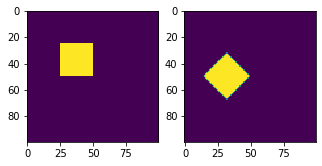

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(img1)

fig.add_subplot(rows, columns, 2)
plt.imshow(img2)

plt.show()


In [ ]:
img = img1[y1:y2+1, x1:x2+1]

NameError: ignored

In [ ]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [ ]:
print(bbox2(img1))

(25, 49, 25, 49)


In [ ]:
print(bbox2(img2))

(32, 67, 14, 49)


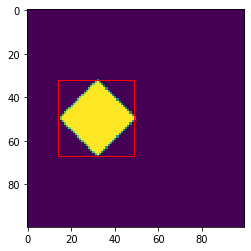

In [ ]:
# Create figure and axes
img = img2
fig,ax = plt.subplots(1)
rmin, rmax, cmin, cmax = bbox2(img)
# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((cmin,rmin), cmax - cmin, rmax - rmin,  linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [ ]:
x = np.float(-2)
y = np.uint8(x)
print(y)

x = np.uint16(1500)
y = np.float32(x)
print(y)

254
1500.0


In [ ]:
a = np.array(
[[[10,2,3],
 [4,5,6],
 [7,8,9]],

[[9,8,7],
 [6,5,4],
 [3,2,1]],

[[10,2,3],
 [4,5,6],
 [7,8,9]],

[[9,8,7],
 [6,5,4],
 [3,2,100]],

[[10,2,3],
 [4,5,6],
 [7,8,9]],
 
 [[10,2,3],
 [4,5,6],
 [7,8,9]]]
 
 )

In [ ]:
b = (a - np.min(a)) // (np.max(a) - np.min(a))

In [ ]:
b

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [ ]:
x = np.array([[[0], [1], [2]]])
x.shape

(1, 3, 1)

In [ ]:
# x = x.reshape((1,3))
np.squeeze(x, axis=-1).shape
# x.shape

(1, 3)

In [ ]:
for i in range(3):
  print(i)

0
1
2


In [ ]:
for i in range(20):
  print(randint(1,3))

2
3
1
1
1
2
1
1
3
2
3
2
1
1
1
2
3
3
2
3


In [ ]:
random

AttributeError: ignored

In [ ]:
'np.random.shuffle(a, seed)

In [ ]:
a

array([[ 6,  5,  4,  5,  6,  7,  6,  5],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [14, 13, 12, 13, 14, 15, 14, 13],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [ 2,  1,  0,  1,  2,  3,  2,  1]])

In [ ]:
a = np.delete(a, 1, 0)

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[9, 8, 7],
        [6, 5, 4],
        [3, 2, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

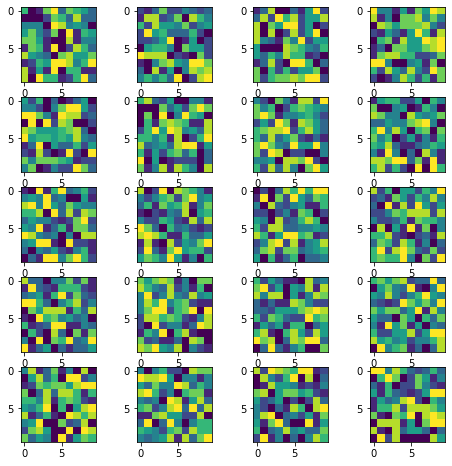

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

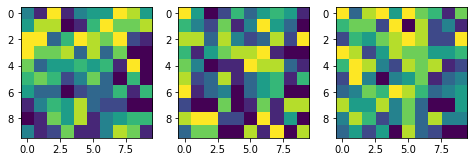

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1

img = np.random.randint(10, size=(h,w))
fig.add_subplot(rows, columns, 1)
plt.imshow(img)

img = np.random.randint(10, size=(h,w))
fig.add_subplot(rows, columns, 2)
plt.imshow(img)

img = np.random.randint(10, size=(h,w))
fig.add_subplot(rows, columns, 3)
plt.imshow(img)

# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
plt.show()

###**Padding**

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


In [ ]:
a = np.arange(16)
a = a.reshape((4, 4))

In [ ]:
a = np.pad(a, ((3,3),(2,2)),mode='reflect')
a

array([[14, 13, 12, 13, 14, 15, 14, 13],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [ 2,  1,  0,  1,  2,  3,  2,  1],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [14, 13, 12, 13, 14, 15, 14, 13],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [ 2,  1,  0,  1,  2,  3,  2,  1]])

In [ ]:
np.pad(a, 5)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0, 10,  9,  8,  9, 10, 11, 10,  9,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  6,  5,  4,  5,  6,  7,  6,  5,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  2,  1,  0,  1,  2,  3,  2,  1,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  6,  5,  4,  5,  6,  7,  6,  5,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0, 10,  9,  8,  9, 10, 11, 10,  9,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0, 14, 13, 12, 13, 14, 15, 14, 13,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

In [ ]:
 np.pad(a, (2,3), pad_with, padder=100)
 img_slc = a

In [ ]:
img_slc = np.pad(img_slc,((1,1),(2,2)),mode='constant')
print(img_slc.shape)
print(img)

(10, 12)
[[9 3 8 9 5 9 7 6 1 7]
 [6 7 7 2 9 0 8 2 4 1]
 [2 6 5 7 8 9 8 2 2 9]
 [9 8 2 5 8 7 7 5 5 6]
 [6 9 8 4 2 8 7 8 1 2]
 [2 9 4 0 4 5 7 1 3 4]
 [3 4 7 6 9 8 6 3 4 5]
 [8 5 5 8 4 7 3 0 0 5]
 [4 8 6 2 4 7 3 8 4 4]
 [3 5 2 5 0 8 3 2 0 0]]


In [ ]:
a

array([[10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [ 2,  1,  0,  1,  2,  3,  2,  1],
       [ 6,  5,  4,  5,  6,  7,  6,  5],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [14, 13, 12, 13, 14, 15, 14, 13],
       [10,  9,  8,  9, 10, 11, 10,  9],
       [ 6,  5,  4,  5,  6,  7,  6,  5]])

In [ ]:
result = np.zeros((10,10))
x_offset = (10 - a.shape[0])//2  # 0 would be what you wanted
y_offset = (10 - a.shape[1])//2 # 0 in your case
result[x_offset:a.shape[0]+x_offset,y_offset:a.shape[1]+y_offset] = a
result


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  9.,  8.,  9., 10., 11., 10.,  9.,  0.],
       [ 0.,  6.,  5.,  4.,  5.,  6.,  7.,  6.,  5.,  0.],
       [ 0.,  2.,  1.,  0.,  1.,  2.,  3.,  2.,  1.,  0.],
       [ 0.,  6.,  5.,  4.,  5.,  6.,  7.,  6.,  5.,  0.],
       [ 0., 10.,  9.,  8.,  9., 10., 11., 10.,  9.,  0.],
       [ 0., 14., 13., 12., 13., 14., 15., 14., 13.,  0.],
       [ 0., 10.,  9.,  8.,  9., 10., 11., 10.,  9.,  0.],
       [ 0.,  6.,  5.,  4.,  5.,  6.,  7.,  6.,  5.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

###**Top K**

In [ ]:
def top(k):
  arr = np.zeros((k), dtype=int)
  arr[1] = 1
  print(arr.shape)

In [ ]:
top(10)

(10,)


In [ ]:
arr = np.zeros((20), dtype=int)

In [ ]:
k=1

# segmentation
seg = np.zeros((100,100), dtype='int')
seg[30:70, 40:50] = k
seg[10:20, 10:20] = k


# ground truth
gt = np.zeros((100,100), dtype='int')
gt[30:70, 40:50] = k

dice = np.sum(gt[seg==k])*2.0 / (np.sum(seg) + np.sum(gt))

print ('Dice similarity score is {}'.format(dice))

Dice similarity score is 0.8888888888888888


###**astype conversion**

In [ ]:
x = np.array([8.9, 6.9, 5.2])
y = np.round(x).astype('uint8')
print(y)

[9 7 5]


In [ ]:
12

### **Save predicted slices as Nifti file**

In [ ]:
def save_slices_as_nifti(imgs_masks_test, affine, header):
  new_nifti = nibabel.Nifti1Image(imgs_masks_test, affine=affine , header=header)
  return new_nifti

In [ ]:
# imgs_masks_test = imgs_masks_test.reshape((90, img_rows, img_cols))
# imgs_masks_test = np.uint8(imgs_masks_test)
# imgs_masks_test = resize(imgs_masks_test, (90, 315, 315), preserve_range=True)
# print(imgs_masks_test.shape)
# image_name = 'd066_pre0_dat.nii.gz'
# test_data_path = os.path.join('raw/test/')
# img = nibabel.load(os.path.join(test_data_path, image_name))
# # print(img.get_data().shape)
# new_nifti = save_slices_as_nifti(imgs_masks_test, img.affine, img.header)
# nibabel.save(new_nifti, 'new_nifti')

In [ ]:
ind = get_max_les_ind(masks_val2)
print(ind)

371


###**Class Weights**

In [ ]:
x, y = np.unique(masks_train2, return_counts=True)
print(x, y)
class_weights = [y[0]/ y.sum(), y[1]/y.sum()]
print(class_weights)

[0. 1.] [185856381    134787]
[0.9992753042983202, 0.0007246957016797701]


###**Manual Augmentation**

In [ ]:
# Create image generator
# https://stackoverflow.com/questions/51656000/can-i-augment-images-and-masks-in-keras-just-using-flow-instead-of-flow-from-d
data_gen_args = dict(#width_shift_range=0.2,
                     #height_shift_range=0.2,
                     brightness_range = [0.2,1.0],
                     shear_range = 0.2,
                     zoom_range = 0.2)
image_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
batch_size = 20
def XYaugmentGenerator(X1, y, seed, batch_size, gen = image_datagen):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = gen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield X1i[0], X2i[0]

In [ ]:
# for x, y in XYaugmentGenerator(imgs_train2, masks_train2, seed, batch_size, image_datagen):
#   for img, mask in zip(x,y):
#     stat(img)
#     stat(mask)
#     show_imgs([img, mask])

In [ ]:
def aug_shift(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

def aug_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # print(out.shape)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
        # print(out.shape)
    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


Initial : 
min :  -0.23598772  max :  4.5480957  median :  -0.23598772  avg :  0.18844664
Intensity Rescale : 
min :  -1.0  max :  1.0  median :  -1.0  avg :  -0.8051669
Hist Eq. 
min :  0.8616790771484375  max :  1.0  median :  0.8616790771484375  avg :  0.8713286874965837
Shear : -0.3
min :  -0.23598772  max :  4.484869  median :  -0.23598772  avg :  0.2082787


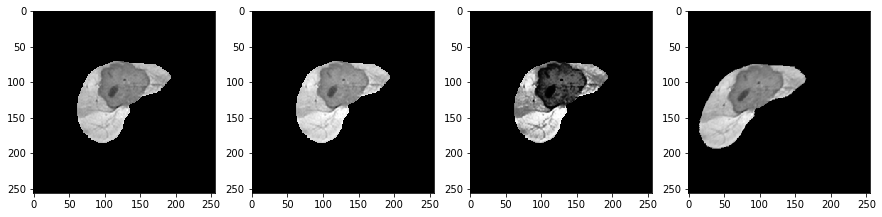

In [ ]:
ind = get_max_les_ind(masks_train2)
img = imgs_train2[ind]
p2, p98 = np.percentile(imgs_train2, (2, 98))
img_ri = exposure.rescale_intensity(img, in_range=(p2, p98))
img_eq = exposure.equalize_hist(img)
shear = round(random.uniform(-0.4, 0.4), 1)
# shear = 0.4
afine_tf = transform.AffineTransform(shear = shear)
img_sh = transform.warp(img, inverse_map = afine_tf, mode='reflect')
print('Initial : ')
stat(img)
print('Intensity Rescale : ')
stat(img_ri)
print('Hist Eq. ')
stat(img_eq)
print('Shear : '+ str(shear))
stat(img_sh)
show_imgs([img, img_ri, img_eq, img_sh])

In [ ]:
show_imgs([img_sh])

In [ ]:
img_sh = img_sh.reshape((img_rows, img_cols))
img_sh[50,200]
img_sh[200, 50]

0.0

In [ ]:
def get_aug_data_eq(imgs, masks):
  # print(imgs.shape)
  shift_range = 30
  p2, p98 = np.percentile(imgs, (2, 98)) 
  aug_imgs = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.float32)
  aug_masks = np.ndarray((masks.shape[0], img_rows, img_cols, 1), dtype=np.float32)
  rand = randint(1,3) # Only 
  sh_x = randint(-shift_range,shift_range)
  sh_y = randint(-shift_range,shift_range)
  shear = round(random.uniform(-0.4, 0.4), 1)
  scale_factor = round(np.random.uniform(0.8,1.2),1)
  for ind in range(len(imgs)):
    img = imgs[ind]
    mask = masks[ind]
    # print('Rand Value : ' + str(rand))
    # print('Before Trans : ')
    # show_imgs([img, mask])

    if rand == 1: 
      print('01 : Scale : Factor ' + str(scale_factor))
      # print('img')
      img = aug_zoom(img, scale_factor)
      # print('mask')
      mask = aug_zoom(mask, scale_factor)

    elif rand == 2:
      print('02 : Shift : ' + str(sh_x) + str(' ') + str(sh_y))
      img = aug_shift(img, sh_x, sh_y)
      mask = aug_shift(mask, sh_x, sh_y)
               
    elif rand == 3:
      print('03 : Shear : Value - ' + str(shear))
      afine_tf = transform.AffineTransform(shear = shear)
      img = transform.warp(img, inverse_map = afine_tf, mode='reflect')
      mask = transform.warp(mask, inverse_map = afine_tf, mode = 'reflect')

    elif rand == 4:
      print('04 : Hist Eq')
      img = exposure.equalize_hist(img)

    elif rand == 5:
      print('05 : Exposure Rescale')
      img = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    # show_imgs([img, mask])
    # print(img.shape)
    # print(mask.shape)
    aug_imgs[ind] = img.reshape((img_rows, img_cols, 1))
    aug_masks[ind] = mask.reshape((img_rows, img_cols, 1))
    # input()
  return aug_imgs, aug_masks

In [ ]:
#3D Augmentation
x = imgs_train2
y = masks_train2
for i in range(3):
  for k in range(rft):
    print('Rep : ' + str(i) + ' Record : ' + str(k))
    aug_imgs, aug_masks = get_aug_data_eq(np.squeeze(x[nslices*k:nslices*(k+1)], axis=-1), np.squeeze(y[nslices*k:nslices*(k+1)], axis=-1))
    imgs_train2 = np.concatenate((imgs_train2, aug_imgs), axis = 0)
    masks_train2 = np.concatenate((masks_train2, aug_masks), axis = 0)

In [ ]:
imgs_train2.shape

(12212, 256, 256, 1)

In [ ]:
# x = imgs_val2
# y = masks_val2
# for i in range(3):
#   aug_imgs, aug_masks = get_aug_data(np.squeeze(x, axis=-1), np.squeeze(y, axis=-1))
#   imgs_val2 = np.concatenate((imgs_val2, aug_imgs), axis = 0)
#   masks_val2 = np.concatenate((masks_val2, aug_masks), axis = 0)

In [ ]:
# Adding Masks as input while training
# imgs_train2 = np.concatenate((imgs_train2, y), axis = 0)
# masks_train2 = np.concatenate((masks_train2, y), axis = 0)

In [ ]:
imgs_train2.shape, masks_train2.shape, gslice_ind2.shape, imgs_val2.shape, masks_val2.shape

((2664, 256, 256, 1),
 (2664, 256, 256, 1),
 (833,),
 (167, 256, 256, 1),
 (167, 256, 256, 1))

In [ ]:
# Contrast stretching
def contrast_stretching(imgs_train2):
  p2, p98 = np.percentile(imgs_train2, (2, 98))
  imgs_train2 = exposure.rescale_intensity(imgs_train2, in_range=(p2, p98))
  return imgs_train2

In [ ]:
# imgs_train2 = contrast_stretching(imgs_train2)

In [ ]:
# # Histogram Equalization
# imgs_train2_he = exposure.equalize_hist(imgs_train2)

In [ ]:
# imgs_train2_he_cs = exposure.rescale_intensity(imgs_train2_he, in_range=(p2, p98))
# imgs_train2_cs_he = exposure.equalize_hist(imgs_train2_cs)

In [ ]:
# show_imgs([imgs_train2[ind], imgs_train2_cs[ind], imgs_train2_he[ind], imgs_train2_cs_he[ind], imgs_train2_he_cs[ind]])

In [ ]:
# # Adaptive Equalization
# imgs_train2 = exposure.equalize_adapthist(imgs_train2, clip_limit=0.03)

###**Discarded U-Nets**

In [ ]:
def get_unet2():
    inputs = Input((img_rows, img_cols, 1))
    nf = 16
    d_rate = 0.5
    reg_factor = 0.0
    SpatialDropout2D(d_rate)
    conv1 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = Conv2D(nf, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    SpatialDropout2D(d_rate)
    conv2 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = Conv2D(nf * 2, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    SpatialDropout2D(d_rate)
    conv3 = Conv2D(nf * 4, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    SpatialDropout2D(d_rate)
    conv4 = Conv2D(nf * 8, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = Conv2D(nf * 8, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # SpatialDropout2D(d_rate)
    # conv5 = Conv2D(nf * 16, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool4)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = tf.keras.activations.relu(conv5)
    # conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = tf.keras.activations.relu(conv5)

    # up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6 = conv4
    # SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    # up7 = conv3
    # SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3),kernel_regularizer=l1(reg_factor), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3),  padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    # SpatialDropout2D(d_rate)
    conv8 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    SpatialDropout2D(d_rate)
    conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    # SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)

    # SpatialDropout2D(d_rate)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [ ]:
def get_3Dunet():
    nf = 48
    d_rate = 0.2
    reg_factor = 0.0
    #Input shape : (z, x, y, c)
    inputs = Input((patch_size[2], patch_size[0], patch_size[1], 1))
    SpatialDropout3D(d_rate)
    conv1 = Conv3D(nf, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = Conv3D(nf, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    SpatialDropout3D(d_rate)
    conv2 = Conv3D(nf * 2, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = Conv3D(nf * 2, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    SpatialDropout3D(d_rate)
    conv3 = Conv3D(nf * 4, (3, 3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = Conv3D(nf * 4, (3, 3, 3),  padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    SpatialDropout2D(d_rate)
    conv4 = Conv3D(nf * 8, (3, 3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = Conv3D(nf * 8, (3, 3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    SpatialDropout3D(d_rate)
    conv5 = Conv3D(nf * 16, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    conv5 = Conv3D(nf * 16, (3, 3, 3),  padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)

    up6 = concatenate([Conv3DTranspose(nf * 8, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=-1)
    SpatialDropout3D(d_rate)
    conv6 = Conv3D(nf * 8, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    SpatialDropout3D(d_rate)
    conv6 = Conv3D(nf * 8, (3, 3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv3DTranspose(nf * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=-1)
    # up7 = conv3
    SpatialDropout3D(d_rate)
    conv7 = Conv3D(nf * 4, (3, 3, 3),kernel_regularizer=l1(reg_factor), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    SpatialDropout3D(d_rate)
    conv7 = Conv3D(nf * 4, (3, 3, 3),  padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv3DTranspose(nf * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=-1)
    # up8 = conv2
    SpatialDropout3D(d_rate)
    conv8 = Conv3D(nf * 2, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    SpatialDropout3D(d_rate)
    conv8 = Conv3D(nf * 2, (3, 3, 3),  padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv3DTranspose(nf, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=-1)
    # up9 = conv1
    SpatialDropout3D(d_rate)
    conv9 = Conv3D(nf, (3, 3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    SpatialDropout3D(d_rate)
    conv9 = Conv3D(nf, (3, 3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)

    SpatialDropout3D(d_rate)
    conv10 = Conv3D(1, (1, 1, 1))(conv9)
    conv10 = Activation('sigmoid', dtype='float32')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

def get_2Dunet():
    inputs = Input((img_rows, img_cols, 1))
    nf = 32
    d_rate = 0.3
    reg_factor = 0.0002
    conv1 = SpatialDropout2D(d_rate)(inputs)
    conv1 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = Conv2D(nf, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = SpatialDropout2D(d_rate)(pool1)
    conv2 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = Conv2D(nf * 2, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = SpatialDropout2D(d_rate)(pool2)
    conv3 = Conv2D(nf * 4, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = SpatialDropout2D(d_rate)(pool3)
    conv4 = Conv2D(nf * 8, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = Conv2D(nf * 8, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = SpatialDropout2D(d_rate)(pool4)
    conv5 = Conv2D(nf * 16, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv5)
    # conv5 = Conv2D(, (1, 1), activation='relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)

    up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = SpatialDropout2D(d_rate)(up6)
    conv6 = Conv2D(nf * 8, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    # up7 = conv3
    conv7 = SpatialDropout2D(d_rate)(up7)
    conv7 = Conv2D(nf * 4, (3, 3),kernel_regularizer=l1(reg_factor), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    conv7 = SpatialDropout2D(d_rate)(conv7)
    conv7 = Conv2D(nf * 4, (3, 3),  padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    conv8 = SpatialDropout2D(d_rate)(up8)
    conv8 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    conv8 = SpatialDropout2D(d_rate)(conv8)
    conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    conv9 = SpatialDropout2D(d_rate)(up9)
    conv9 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    conv9 = SpatialDropout2D(d_rate)(conv9)
    conv9 = Conv2D(nf, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)

    conv9 = SpatialDropout2D(d_rate)(conv9)
    conv10 = Conv2D(1, (1, 1))(conv9)
    conv10 = Activation('sigmoid', dtype='float32')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


def get_unet_simple():

    nf = 64
    inputs = Input((patch_size[0], patch_size[1], 1))
    
    conv1 = Conv2D(nf, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(nf, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(nf * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(nf * 16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(nf, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(nf, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model


###**Data prep for training before using Batch Generators**

In [ ]:
#Using tf.data.Dataset
batch_size = 1
imgs_train2_f = tf.convert_to_tensor(imgs_train2)
masks_train2_f = tf.convert_to_tensor(masks_train2)
train_data = tf.data.Dataset.from_tensor_slices((imgs_train2_f, masks_train2_f))
train_data = train_data.batch(batch_size*nslices).shuffle(batch_size*nslices*100).repeat()

imgs_val2_f = tf.convert_to_tensor(imgs_val2)
masks_val2_f = tf.convert_to_tensor(masks_val2)
val_data = tf.data.Dataset.from_tensor_slices((imgs_val2_f, masks_val2_f))
val_data = val_data.batch(batch_size*nslices).shuffle(batch_size*nslices).repeat()

###**[Iterables, Generators and Yield](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do)**

In [ ]:
mygenerator = (x*x for x in range(10))
for i in mygenerator:
  print(i)
  break

0


In [ ]:
for i in mygenerator:
  print(i)

1
4
9
16
25
36
49
64
81


###**BatchGenerator**

In [ ]:
def generator2(gen):
    #Using only 64 slices to make it compatible with 3D Unet
    img_batch_f = np.ndarray((64*batch_size, img_rows, img_cols, 1))
    mask_batch_f = np.ndarray((64*batch_size, img_rows, img_cols, 1))
    rec_batch_f = []
    for i in range(batch_size):
        batch = next(gen)
        img_batch = batch['data'][0][0]
        mask_batch = batch['seg'][0][0]
        rec_batch =  batch['names'][0]
        print(rec_batch)
        img_batch = np.rollaxis(img_batch, 2,0)
        mask_batch = np.rollaxis(mask_batch, 2,0)        
        img_batch = img_batch[11:-11]
        mask_batch = mask_batch[11:-11]
        img_batch = img_batch[...,np.newaxis]
        mask_batch = mask_batch[..., np.newaxis]
        img_batch_f[i*64:(i+1)*64] = img_batch
        mask_batch_f[i*64:(i+1)*64] = mask_batch
        rec_batch_f.append(rec_batch)
    img_batch_f = img_batch_f[np.newaxis,...]
    mask_batch_f = mask_batch_f[np.newaxis,...]
    return (img_batch_f, mask_batch_f)
    # yield(img_batch_f, mask_batch_f)

###**Renaming Files for BatchGenerators**

In [ ]:
os.chdir("DataForBatchGenerators")
img_path = glob("volume-*.nii.npy")
mask_path = glob("segmentation-*.nii.npy")
img_path.sort()
mask_path.sort()
# img_path = img_path[:44]
# mask_path = mask_path[:44]
img_path = [i[:-4] for i in img_path]
mask_path = [i[:-4] for i in mask_path]
print("Number of images :", len(img_path), len(mask_path))
os.chdir("..")
np.save('eda_files/record_dat.npy', img_path)
np.save('eda_files/record_seg.npy', mask_path)
img_path = np.load('eda_files/record_dat.npy')
seg_path = np.load('eda_files/record_seg.npy')
img_path, seg_path

###**Load and change Dimensions**

In [ ]:
# Snippet for loading and changing dimensions
img_names = np.load('eda_files/record_dat.npy')
mask_names = np.load('eda_files/record_seg.npy')
for ind in range(len(img_names)):
  imgs = np.load('DataForBatchGenerators/' + img_names[ind] + '.npy')
  masks = np.load('DataForBatchGenerators/' + mask_names[ind] + '.npy')
  print(ind, img_names[ind], imgs.shape, masks.shape)
  if(len(imgs.shape) == 4):
    imgs = np.reshape(imgs, ((1, 1, imgs.shape[1], imgs.shape[2], imgs.shape[0])))
    masks = np.reshape(masks,((1, 1, masks.shape[1], masks.shape[2], masks.shape[0])))
    print(ind, img_names[ind], imgs.shape, masks.shape)
    np.save('DataForBatchGenerators/'+ img_names[ind] + '.npy', imgs)
    np.save('DataForBatchGenerators/'+ mask_names[ind] + '.npy', masks)
  # break

###**Change File Names**

In [ ]:
# img_path = glob("DataForBatchGenerators/*dat*") #For Thesis
os.chdir("DataForBatchGenerators")
img_path = glob("*vol*") #For LiTS
mask_path = glob("*seg*")
img_path.sort()
mask_path.sort()
img_path = [i[:-4] for i in img_path]
mask_path = [i[:-4] for i in mask_path]
print("Number of images :", len(img_path), len(mask_path))
os.chdir("..")
np.save("eda_files/record_dat.npy", img_path)
np.save("eda_files/record_seg.npy", mask_path)

###**Trim Data**

In [ ]:
'''
Trim Data
'''
for ind in range(len(img_names)):
  print("--- " + str(ind) + " ---")
  imgs = np.load('DataForBatchGenerators/' + img_names[ind])
  masks = np.load('DataForBatchGenerators/' + mask_names[ind])
  imgs, masks = trim_data(imgs, masks)
  imgs = np.clip(imgs, -100, 400)
  np.save('TrimmedDataForBatchGenerators/' + img_names[ind], imgs)
  np.save('TrimmedDataForBatchGenerators/' + mask_names[ind], masks)
  # break

###**Elastic Deform**

In [ ]:
# Import stuff
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [ ]:
x = np.squeeze(imgs)
y = np.squeeze(masks)
x.shape, y.shape

In [ ]:
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

# Load images
im = cv2.imread("10_100.tif", -1)
im_mask = cv2.imread("10_100_mask.tif", -1)

# Draw grid lines
draw_grid(im, 50)
draw_grid(im_mask, 50)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
print(im.shape, im.dtype)

In [ ]:
# Thesis
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

# Load images
ind = 60
im = x[:,:,ind]
im_mask = y[:,:,ind]

im = im.astype('uint16')
im_mask = im_mask.astype('uint8')
im_mask[im_mask == 1] = 255

# Draw grid lines
draw_grid(im, 50)
draw_grid(im_mask, 50)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
print(im.shape, im.dtype)

In [ ]:
np.unique(im_mask, return_counts=True)

In [ ]:
show_imgs2([im, im_mask])

In [ ]:
# np.save('im.npy', im)
# np.save('im_mask.npy', im_mask)

In [ ]:
im_merge.shape

In [ ]:
# First sample...

# %matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (10,10))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')

In [ ]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=3, mode='constant').reshape(shape)

###**Data prep from .nii to rescaled, trimmed batgen**

In [ ]:
for img_name, mask_name in zip(img_names, mask_names):
  print(img_name)
  img_orig_nii = nibabel.load(raw_data_path + img_name)
  # print(img_orig_nii.affine)
  # print(img_orig_nii.header.get_zooms())
  # imgs_orig = img_orig_nii.get_fdata()
  # print(imgs_orig.shape)
  img_resampled_nii = resample_img(img_orig_nii, target_affine=targ_affine, interpolation='continuous')
  # print(img_resampled_nii.affine)
  # print(img_resampled_nii.header.get_zooms())
  imgs_resampled = np.array(img_resampled_nii.get_fdata(), dtype='float32')
  print(imgs_resampled.shape)

  print(mask_name)
  masks_orig_nii = nibabel.load(raw_seg_path + mask_name)
  # print(masks_orig_nii.affine)
  # print(masks_orig_nii.header.get_zooms())
  # masks_orig = masks_orig_nii.get_fdata()
  # print(masks_orig.shape)
  masks_resampled_nii = resample_img(masks_orig_nii, target_affine=targ_affine, interpolation='nearest')
  # print(masks_resampled_nii.affine)
  # print(masks_resampled_nii.header.get_zooms())
  masks_resampled = np.array(masks_resampled_nii.get_fdata(), dtype='uint8')
  print(masks_resampled.shape)

  # imgs_resampled[imgs_resampled>1200] = 0
  # imgs_resampled = np.clip(imgs_resampled, -100, 400)
  imgs_resampled = np.rot90(imgs_resampled)
  imgs_resampled = np.fliplr(imgs_resampled)
  masks_resampled = np.rot90(masks_resampled)
  masks_resampled = np.fliplr(masks_resampled)
  min_, max_ = float(np.min(imgs_resampled)), float(np.max(imgs_resampled))
  imgs_resampled = (imgs_resampled - min_) / (max_ - min_)
  imgs_resampled = imgs_resampled * np.clip(masks_resampled, 0, 1)
  stat(imgs_resampled)
  masks_resampled[masks_resampled == 1] = 0
  masks_resampled[masks_resampled == 2] = 1 
  imgs_resampled, masks_resampled = trim_data(imgs_resampled, masks_resampled)
  np.save('ResampledTrimmedDataForBatchGenerators/data/' + img_name + '.npy', imgs_resampled)
  np.save('ResampledTrimmedDataForBatchGenerators/seg/' + mask_name + '.npy', masks_resampled)
  break

In [ ]:
os.chdir(raw_data_path)
img_names = glob("*pre*nii*")
os.chdir(raw_seg_path)
mask_names = glob("*pre*nii*")
os.chdir(project_path)
img_names.sort()
mask_names.sort()
# img_names = [i[:-4] for i in img_names]

In [ ]:
len(img_names), len(mask_names), img_names[0], mask_names[0]

(54, 54, 'd001_pre0_dat.nii.gz', 'd001_pre0_seg.nii.gz')

In [ ]:
targ_affine = np.eye(3)
print(targ_affine)
# targ_affine[0][0] = -1 # for LiTS
# print(targ_affine)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
for img_name, mask_name in zip(img_names, mask_names):
  print(img_name, mask_name)
  img_orig_nii = nibabel.load(raw_data_path + img_name)
  img_resampled_nii = resample_img(img_orig_nii, target_affine=targ_affine, interpolation='continuous')
  imgs_resampled = np.array(img_resampled_nii.get_fdata(), dtype='float32')

  masks_orig_nii = nibabel.load(raw_seg_path + mask_name)
  masks_resampled_nii = resample_img(masks_orig_nii, target_affine=targ_affine, interpolation='nearest')
  masks_resampled = np.array(masks_resampled_nii.get_fdata(), dtype='uint8')
  print(imgs_resampled.shape, masks_resampled.shape)

  # imgs_resampled[imgs_resampled>1200] = 0 #for CT
  # imgs_resampled = np.clip(imgs_resampled, -100, 400) #for CT
  imgs_resampled = np.rot90(imgs_resampled)
  imgs_resampled = np.fliplr(imgs_resampled) #for Thesis Dataset
  masks_resampled = np.rot90(masks_resampled) 
  masks_resampled = np.fliplr(masks_resampled) #for Thesis Dataset

  min_, max_ = float(np.min(imgs_resampled)), float(np.max(imgs_resampled))
  imgs_resampled = (imgs_resampled - min_) / (max_ - min_)

  imgs_resampled = imgs_resampled * np.clip(masks_resampled, 0, 1)
  stat(imgs_resampled)
  masks_resampled[masks_resampled == 1] = 0
  masks_resampled[masks_resampled == 2] = 1 
  imgs_resampled, masks_resampled = trim_data(imgs_resampled, masks_resampled)
  np.save('ResampledTrimmedDataForBatchGenerators/data/' + img_name + '.npy', imgs_resampled)
  np.save('ResampledTrimmedDataForBatchGenerators/seg/' + mask_name + '.npy', masks_resampled)
  # break

###**Check how metrics (dice, precision and recall) change with size of lesions**

###**Kernel Visualization**

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'conv3d'
filter_index = 0 # Which filter in this block would you like to visualise?

# Grab the filters and biases for that layer
filters, biases = layer_dict[layer_name].get_weights()

In [ ]:
# summarize filter shapes
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

conv3d (3, 3, 3, 1, 32)
conv3d_1 (3, 3, 3, 32, 32)
conv3d_2 (3, 3, 3, 32, 64)
conv3d_3 (3, 3, 3, 64, 64)
conv3d_4 (3, 3, 3, 64, 128)
conv3d_5 (3, 3, 3, 128, 128)
conv3d_6 (3, 3, 3, 128, 256)
conv3d_7 (3, 3, 3, 256, 256)
conv3d_8 (3, 3, 3, 256, 512)
conv3d_9 (3, 3, 3, 512, 512)
conv3d_10 (3, 3, 3, 512, 1024)
conv3d_11 (3, 3, 3, 1024, 1024)
conv3d_transpose (2, 2, 2, 512, 1024)
conv3d_12 (3, 3, 3, 1024, 512)
conv3d_13 (3, 3, 3, 512, 512)
conv3d_transpose_1 (2, 2, 2, 256, 512)
conv3d_14 (3, 3, 3, 512, 256)
conv3d_15 (3, 3, 3, 256, 256)
conv3d_transpose_2 (2, 2, 2, 128, 256)
conv3d_16 (3, 3, 3, 256, 128)
conv3d_17 (3, 3, 3, 128, 128)
conv3d_transpose_3 (2, 2, 2, 64, 128)
conv3d_18 (3, 3, 3, 128, 64)
conv3d_19 (3, 3, 3, 64, 64)
conv3d_transpose_4 (2, 2, 2, 32, 64)
conv3d_20 (3, 3, 3, 64, 32)
conv3d_21 (3, 3, 3, 32, 32)
conv3d_22 (1, 1, 1, 32, 1)


In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

###**Feature map Visualization**

In [ ]:
len(model.layers)

67

In [ ]:
[(i, model.layers[i].name) for i in range(len(model.layers))]

[(0, 'input_1'),
 (1, 'conv3d'),
 (2, 'batch_normalization'),
 (3, 'conv3d_1'),
 (4, 'batch_normalization_1'),
 (5, 'max_pooling3d'),
 (6, 'conv3d_2'),
 (7, 'batch_normalization_2'),
 (8, 'conv3d_3'),
 (9, 'batch_normalization_3'),
 (10, 'max_pooling3d_1'),
 (11, 'conv3d_4'),
 (12, 'batch_normalization_4'),
 (13, 'conv3d_5'),
 (14, 'batch_normalization_5'),
 (15, 'max_pooling3d_2'),
 (16, 'conv3d_6'),
 (17, 'batch_normalization_6'),
 (18, 'conv3d_7'),
 (19, 'batch_normalization_7'),
 (20, 'max_pooling3d_3'),
 (21, 'conv3d_8'),
 (22, 'batch_normalization_8'),
 (23, 'conv3d_9'),
 (24, 'batch_normalization_9'),
 (25, 'max_pooling3d_4'),
 (26, 'conv3d_10'),
 (27, 'batch_normalization_10'),
 (28, 'conv3d_11'),
 (29, 'batch_normalization_11'),
 (30, 'conv3d_transpose'),
 (31, 'spatial_dropout3d_5'),
 (32, 'concatenate'),
 (33, 'conv3d_12'),
 (34, 'batch_normalization_12'),
 (35, 'conv3d_13'),
 (36, 'batch_normalization_13'),
 (37, 'conv3d_transpose_1'),
 (38, 'spatial_dropout3d_6'),
 (39, 'c

In [ ]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
#Inference on training batch
imgs, masks = next(train_generator)
preds = model.predict(imgs)
# tf.print(dice_coef(masks, preds), precision(masks, preds), recall(masks, preds))

In [ ]:
imgs.shape, preds.shape

((1, 128, 128, 64, 1), (1, 128, 128, 64, 32))

In [ ]:
imgs = imgs[0,...,0]
preds = preds[0,...,0]

In [ ]:
imgs.shape, preds.shape

((128, 128, 64), (128, 128, 64))

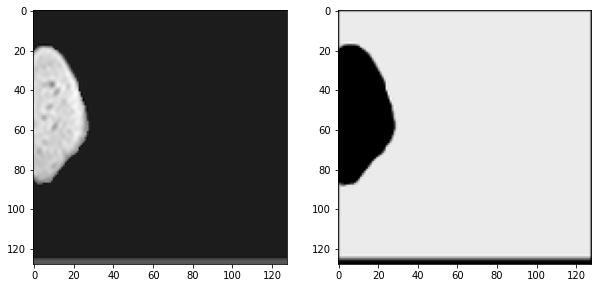

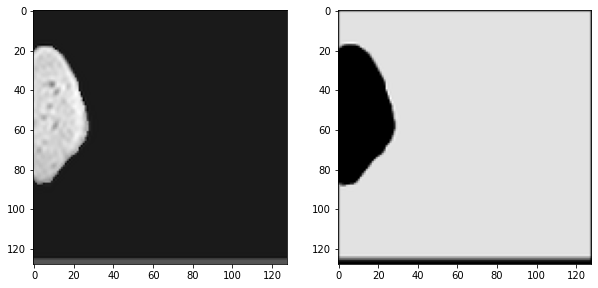

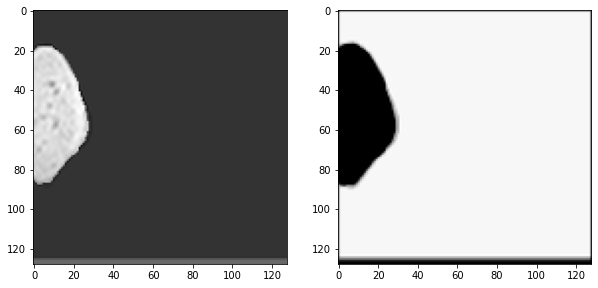

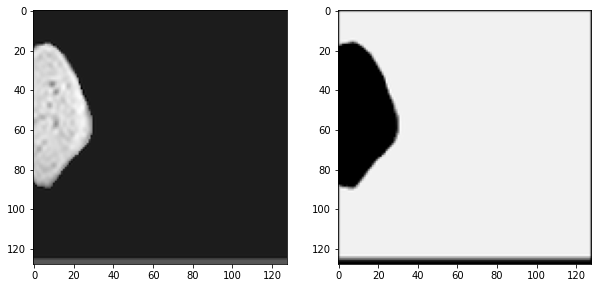

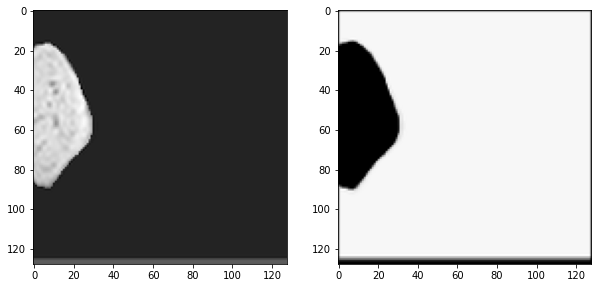

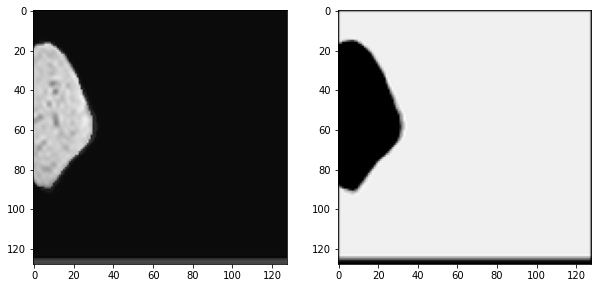

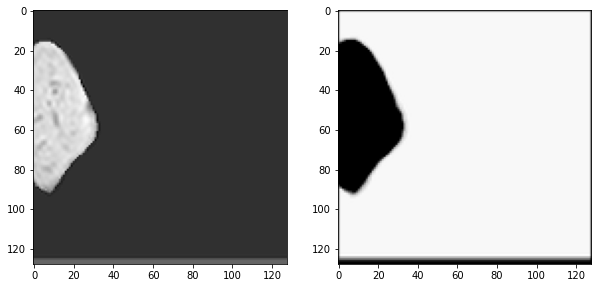

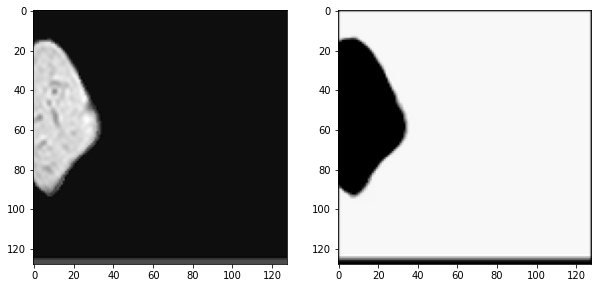

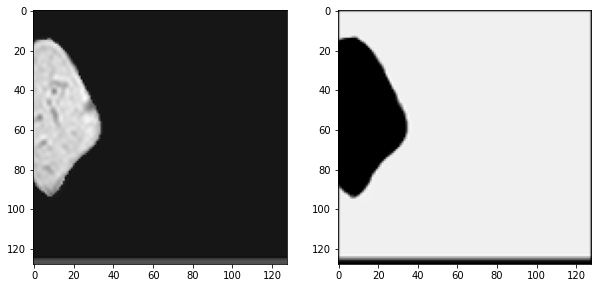

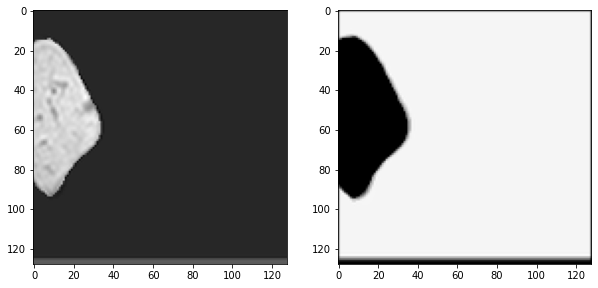

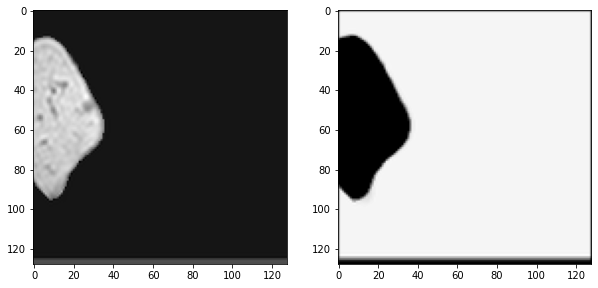

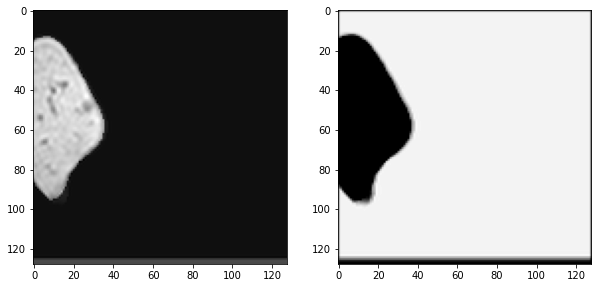

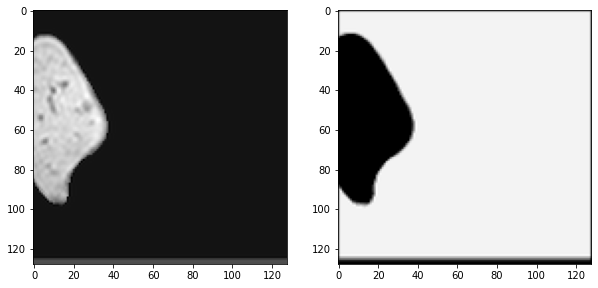

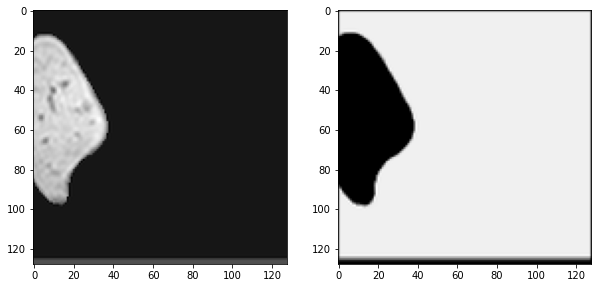

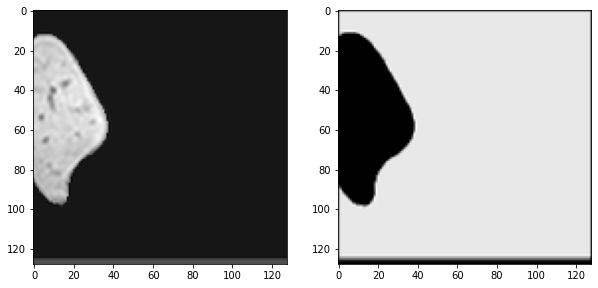

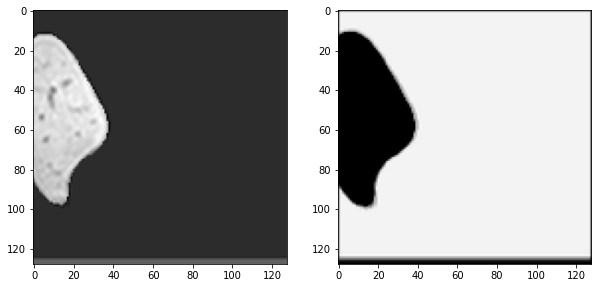

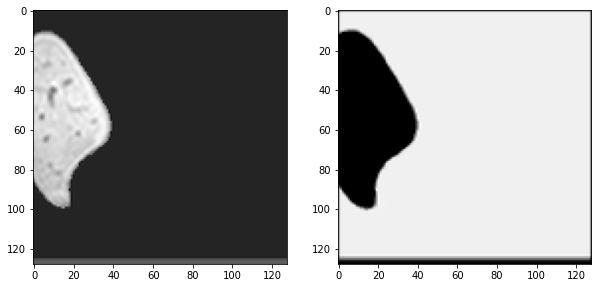

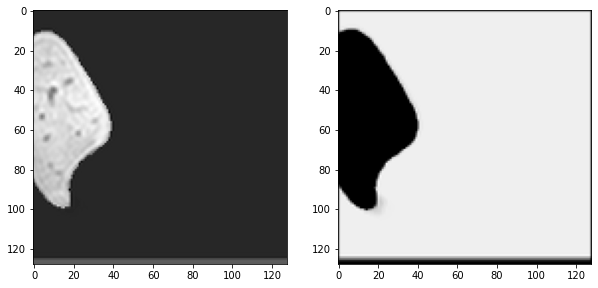

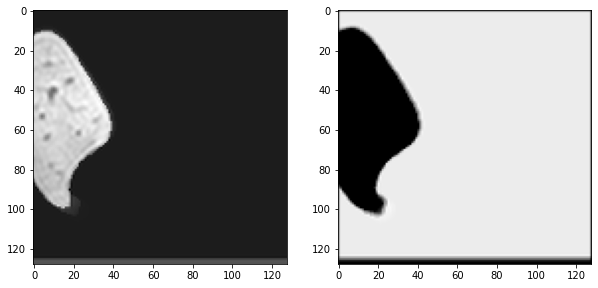

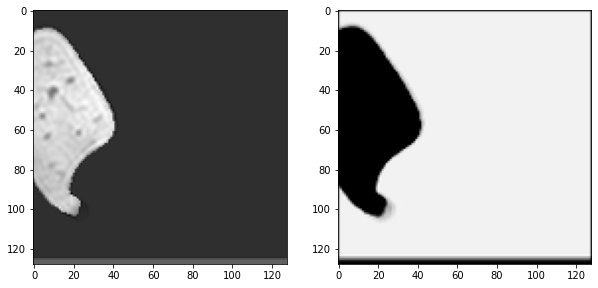

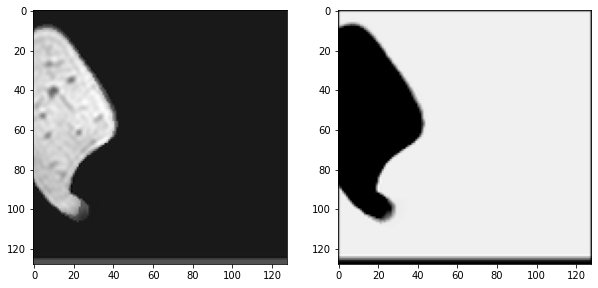

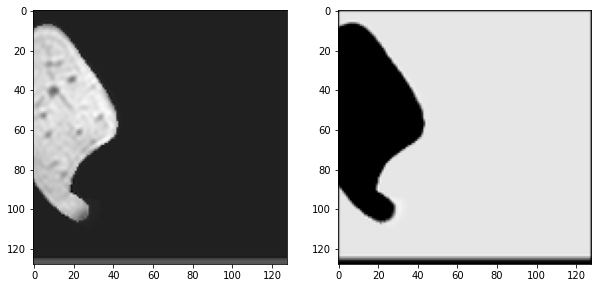

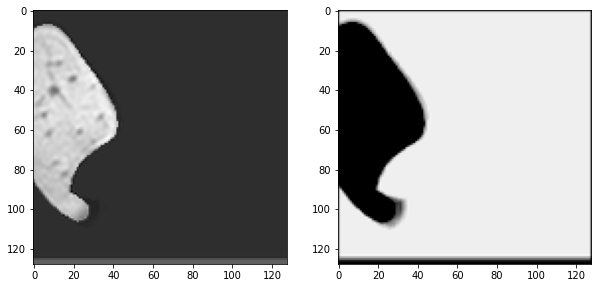

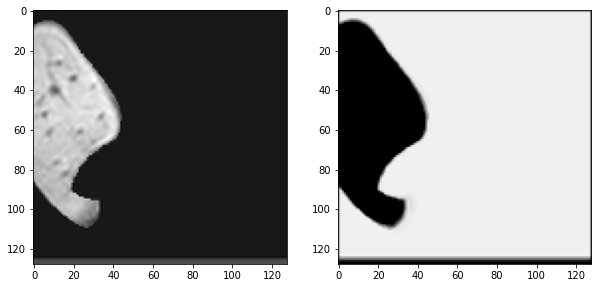

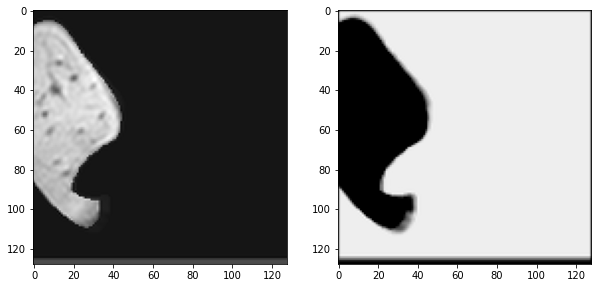

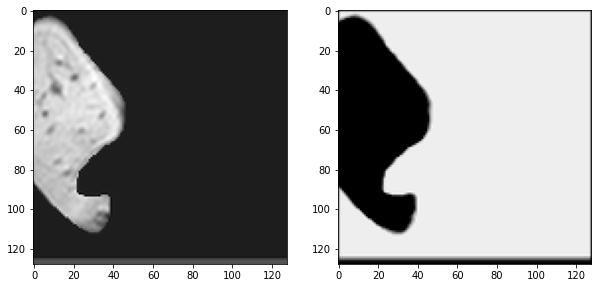

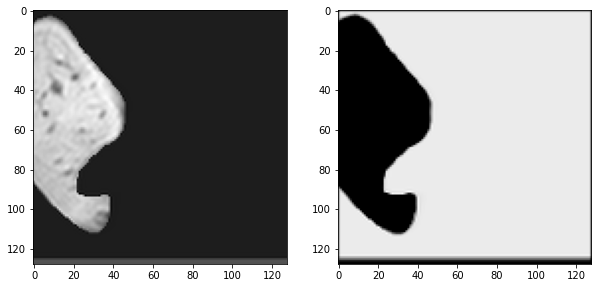

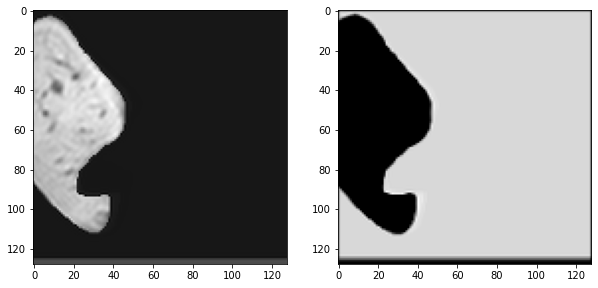

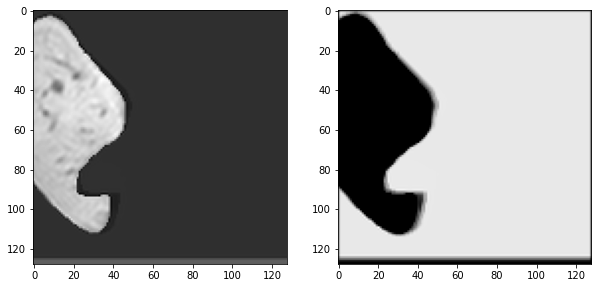

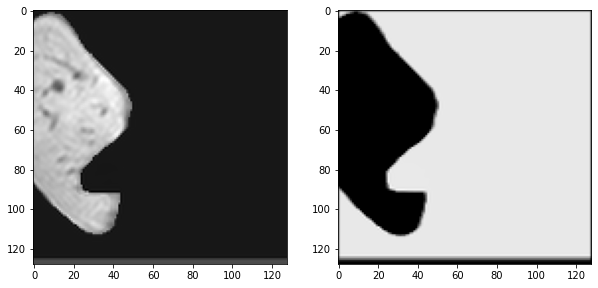

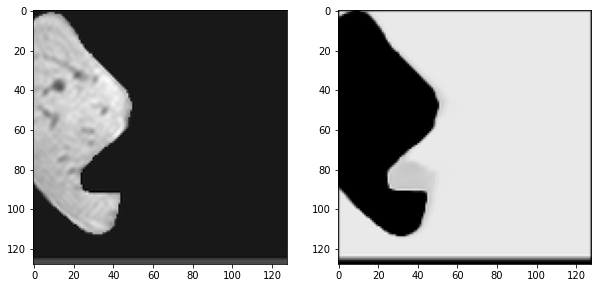

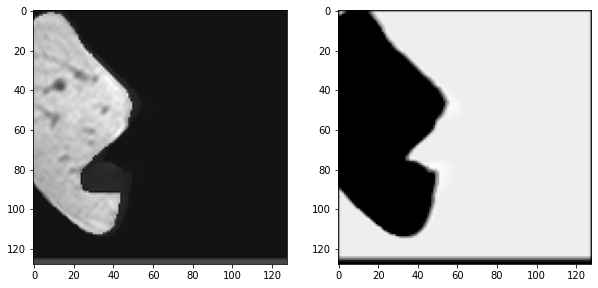

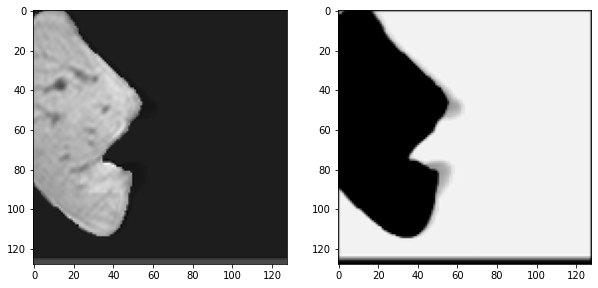

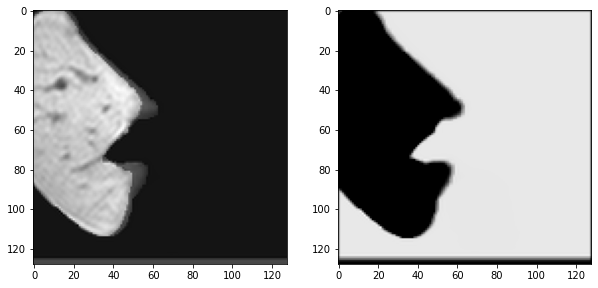

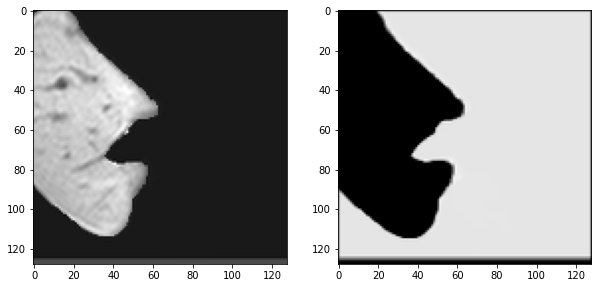

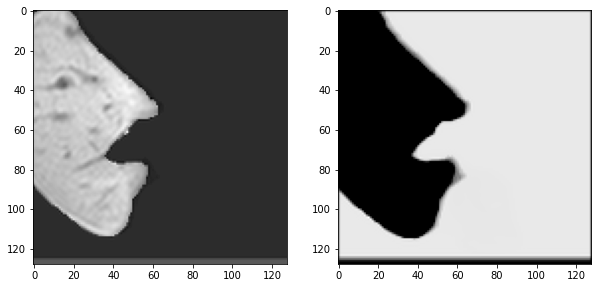

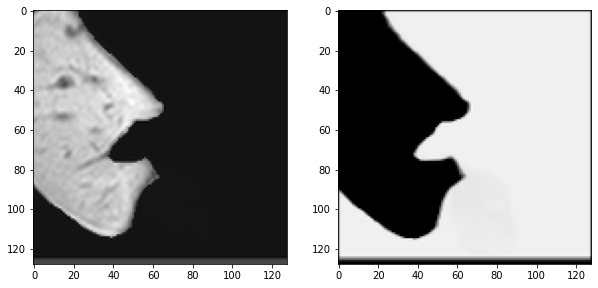

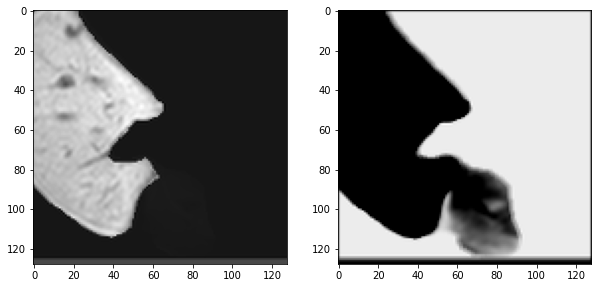

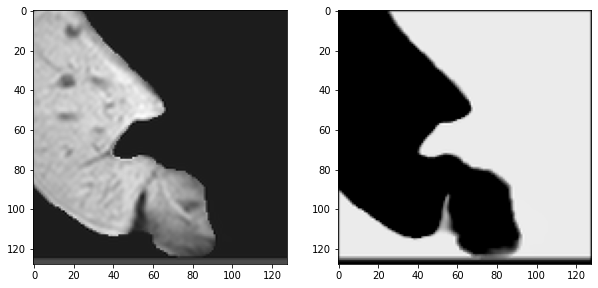

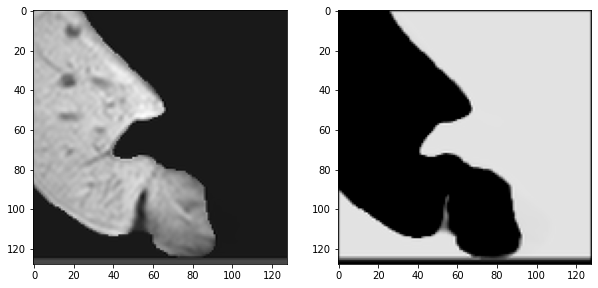

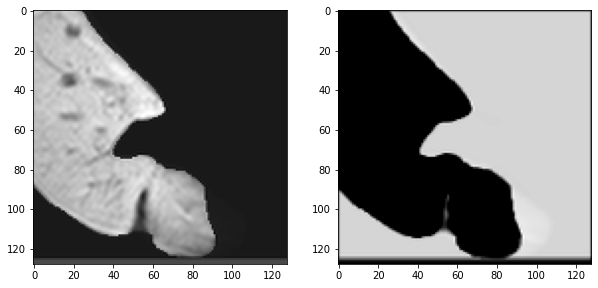

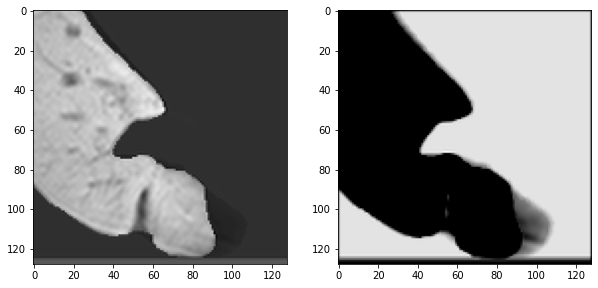

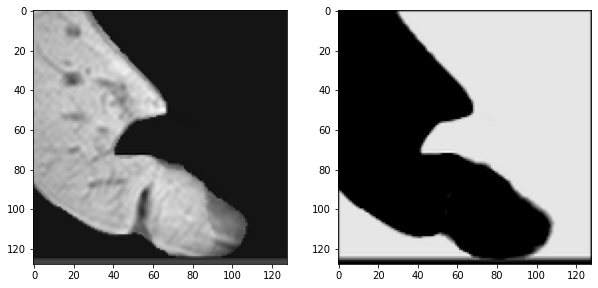

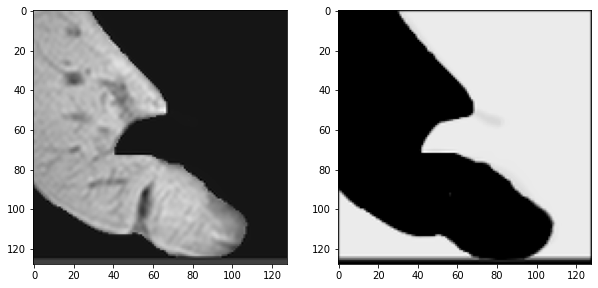

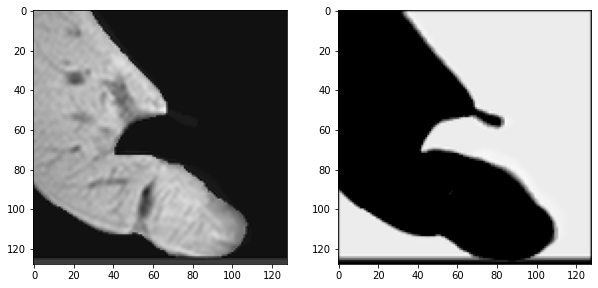

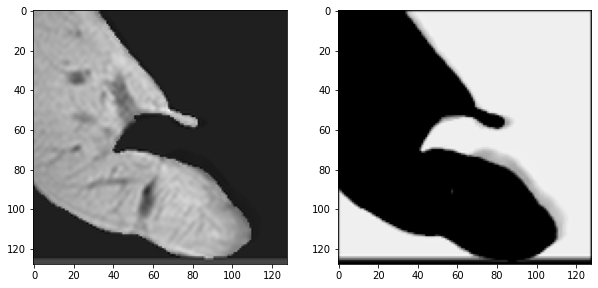

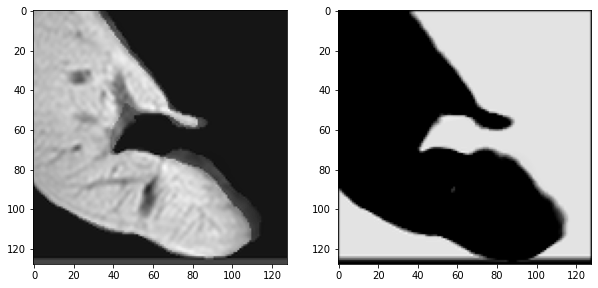

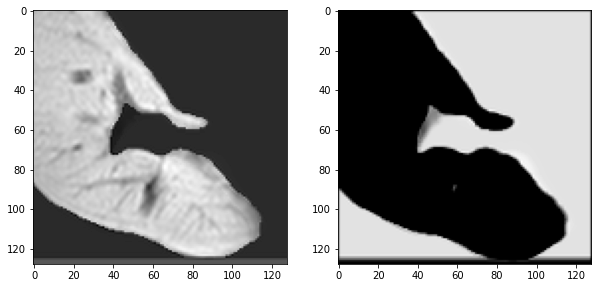

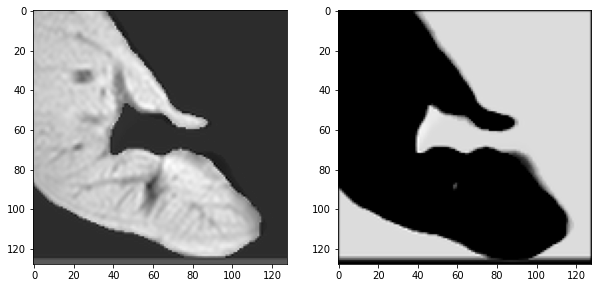

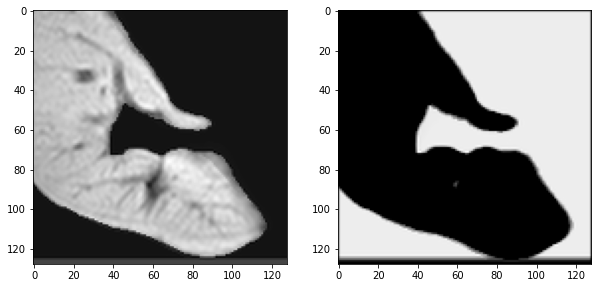

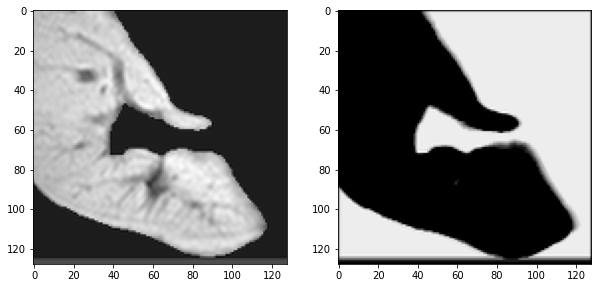

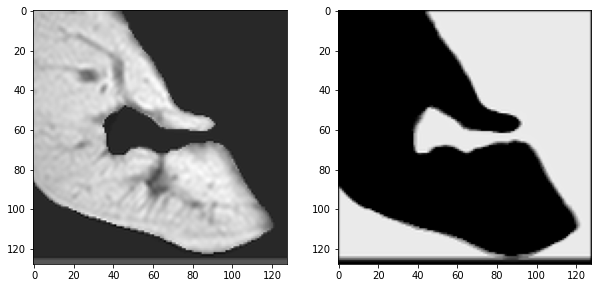

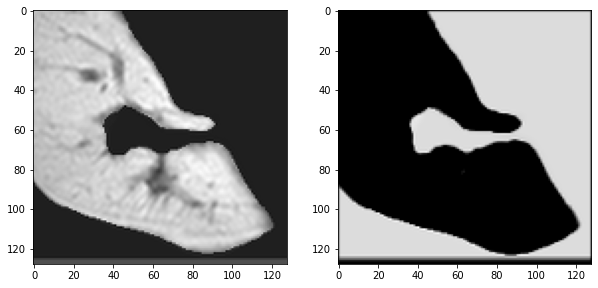

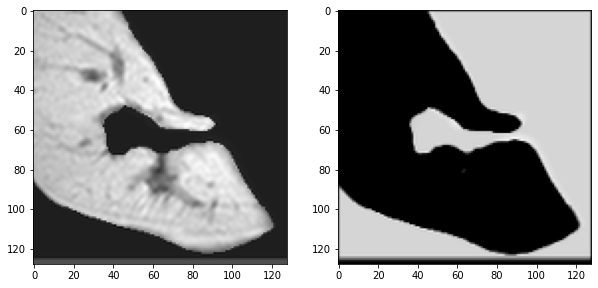

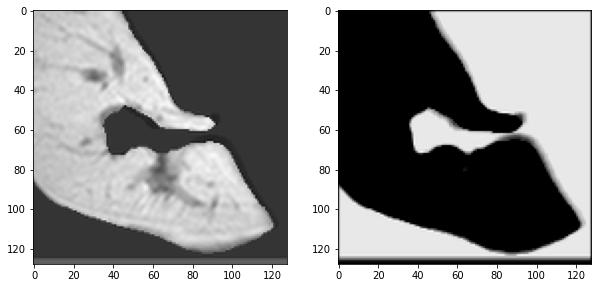

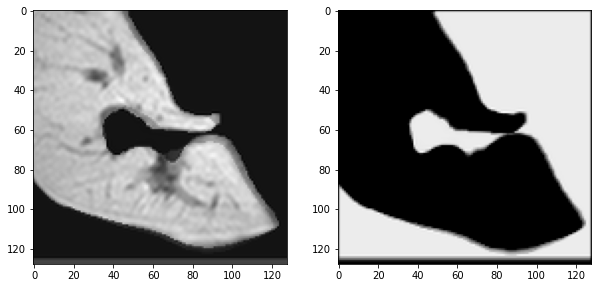

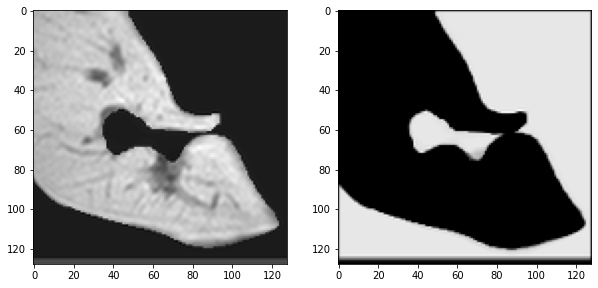

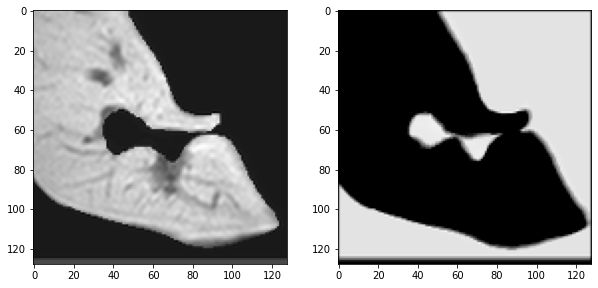

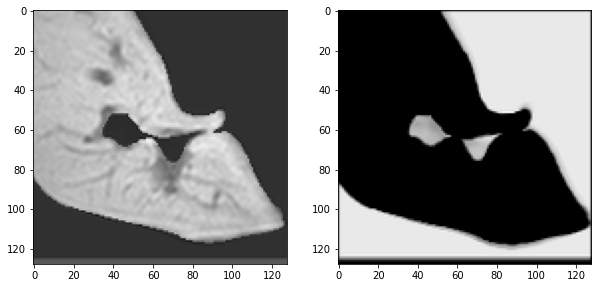

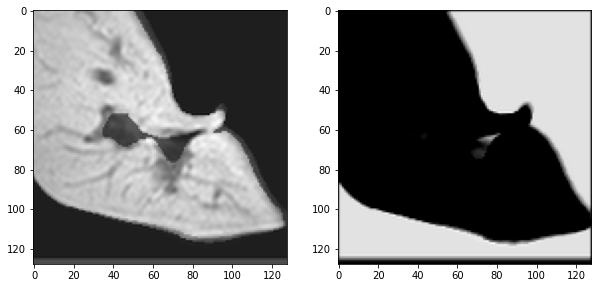

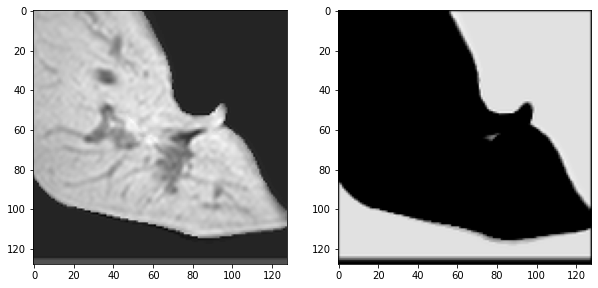

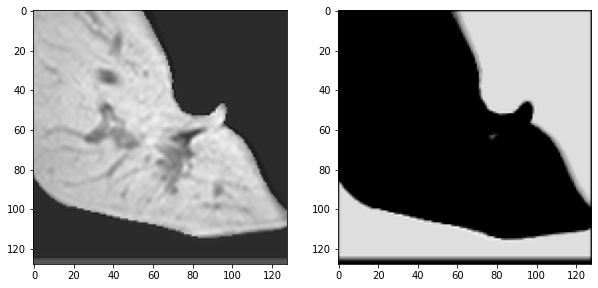

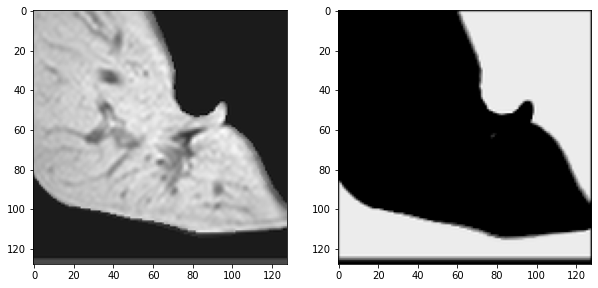

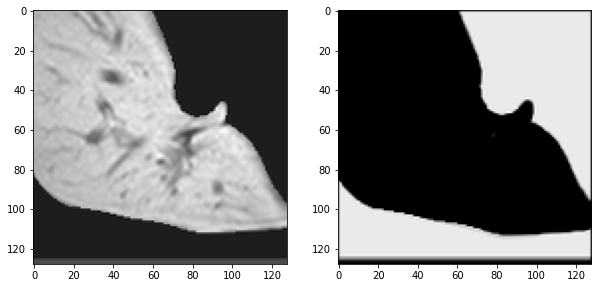

In [ ]:
for i in range(preds.shape[-1]):
  show_imgs([imgs[:,:,i], preds[:,:,i]])